# JCM

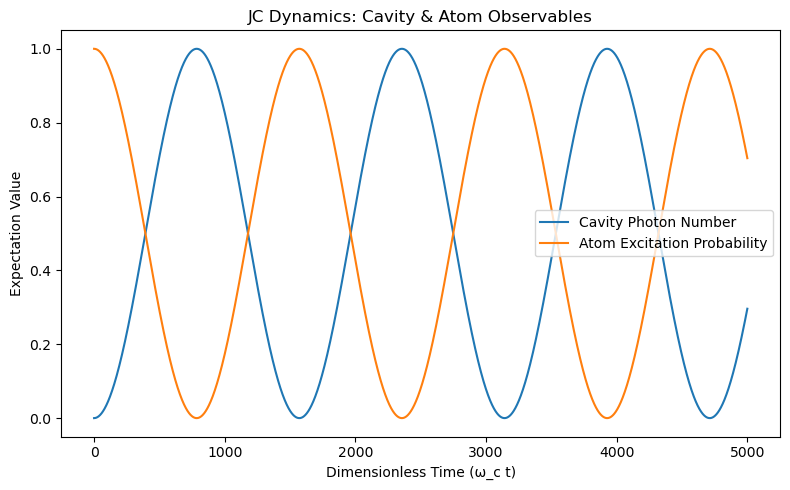

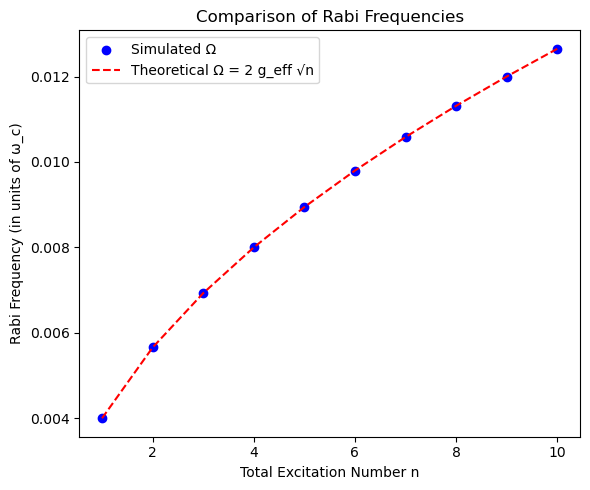

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

# Sayak please look at the comments for the explanation of each step:

# =============================================================================
# Define Experimental Parameters (in SI units)
# =============================================================================
# Experimental values (in Hz)
wc = 2 * np.pi * 5e9   # cavity frequency (5 GHz)
wa = 2 * np.pi * 5e9   # atomic transition frequency (5 GHz)
g  = 2 * np.pi * 1e7   # coupling strength (10 MHz)

# This values were defined by ChatGPT based on similarity with superconducting qubits' values.
# wc and wa are set at resonance, we might change this.

# =============================================================================
# Define Unitless (Dimensionless) Parameters
# =============================================================================
# We factor out ℏ*wc so that the unitless Hamiltonian becomes:
#    H' = a†a + 0.5*(wa/wc)*σ_z + (g/wc)*(a σ⁺ + a† σ⁻)
g_eff = g / wc       # unitless coupling
delta_eff = (wa - wc) / wc  # unitless detuning, this should be zero since wa == wc, set at resonance at the beginning -^

# This follows exactly our initial code.

# =============================================================================
# Set Hilbert Space Dimensions and Define Operators
# =============================================================================
N = 75  # number of cavity Fock states to include, we might increase this but it's basically the same.

# Define operators on the full (cavity ⊗ atom) space.
# Note: In our tensor-product, the cavity Hilbert space is first, and the atom second. This follows qutip documentation.
a      = tensor(destroy(N), qeye(2))   # cavity annihilation operator
adag   = a.dag()                       # cavity creation operator
num_cav = adag * a                     # cavity photon number operator

# Two-level system (atom) operators (QuTiP’s sigmam() and sigmap() use basis |e>,|g> with sigmaz = diag(1, -1))
sm = tensor(qeye(N), sigmam())  # atomic lowering operator
sp = tensor(qeye(N), sigmap())  # atomic raising operator
sz = tensor(qeye(N), sigmaz())  # atomic inversion

# =============================================================================
# Build the Unitary (Time-Independent) Hamiltonian
# =============================================================================
# The standard JC Hamiltonian (with ℏ factored out) is:
#   H = ℏ wc (a†a) + (ℏ wa/2) σ_z + ℏ g (a σ⁺ + a† σ⁻)
# Dividing through by ℏ wc, we get the dimensionless Hamiltonian:
#
#   H' = a†a + 0.5*(wa/wc)*σ_z + (g/wc)*(a σ⁺ + a† σ⁻)
H = num_cav + 0.5 * (wa / wc) * sz + g_eff * (a * sp + adag * sm)

# Again as our initial code.

# =============================================================================
# Time Evolution for a Single Initial State
# =============================================================================
# For example, let us simulate the case where the system has one total excitation.
# In the JC model the total excitation number is N_ex = n_cavity + (σ_z+1)/2.
# For N_ex = 1 the relevant two-level subspace is spanned by:
#      |n=0, e>   and   |n=1, g>
# We choose the initial state to be |0, e> (i.e. cavity vacuum and atom excited).
psi0 = tensor(fock(N, 0), basis(2, 0))

# Choose a time grid in the unitless time variable (wc*t).
# For |0,e> the Rabi frequency in these units is Ω = 2*g_eff (since √1 = 1),
# so the Rabi period is T_R = 2π/(2*g_eff) = π/g_eff.
# With g_eff = g/wc ≈ 1e7/5e9 = 0.002, T_R ~ π/0.002 ≈ 1570.
t_max = 5000
n_steps = 5000
tlist = np.linspace(0, t_max, n_steps) # We chose even higher values for the plot scale, might increase.

# Define the projection onto the excited state (atom) operator:
excited_proj = tensor(qeye(N), basis(2, 0) * basis(2, 0).dag())

# Solve the time-dependent Schrödinger equation (no collapse operators).
result = mesolve(H, psi0, tlist, [], [num_cav, excited_proj])

# Plot the cavity photon number and atomic excitation probability vs. time.
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label="Cavity Photon Number")
plt.plot(tlist, result.expect[1], label="Atom Excitation Probability")
plt.xlabel("Dimensionless Time (ω_c t)")
plt.ylabel("Expectation Value")
plt.title("JC Dynamics: Cavity & Atom Observables")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# Verifying the Simulation: Extracting the Rabi Frequencies
# =============================================================================
# In the JC model, if the total number of excitations is n (n>=1), then if we
# start with the state |n-1, e> (i.e. n-1 photons in the cavity and the atom excited),
# the evolution is confined to the two-level subspace {|n-1, e>, |n, g>}.
# In that manifold the probability oscillates with frequency:
#
#      Ω_theory = 2 * g_eff * √(n)
#
# We now loop over several manifolds (n = 1, 2, ..., n_max) to simulate the evolution,
# extract the oscillation period from the atomic excited-state population, and then compare.
n_manifolds = np.arange(1, 11)  # simulate for n = 1,2,...,10 (total excitation numbers)
omega_exp_list = []  # will hold frequencies extracted from simulation (in units of ω_c)
omega_th_list = []   # theoretical frequencies

for n in n_manifolds:
    # For a total excitation number n, prepare the initial state |n-1, e>
    psi0_n = tensor(fock(N, n-1), basis(2, 0))

    # This should explain why we were getting matching frequencies at this rate. I will tell you more about it.
    
    # For each manifold the Rabi frequency is Ω_theory = 2*g_eff*√(n),
    # and the Rabi period T_R = 2π / Ω_theory.
    Omega_theory = 2 * g_eff * np.sqrt(n)
    T_R = 2 * np.pi / Omega_theory
    omega_th_list.append(Omega_theory)
    
    # Set a time grid that spans a few Rabi periods (say, 3 periods)
    t_max_n = 3 * T_R
    n_steps_n = 1000  # use sufficient resolution for the shorter time scale
    tlist_n = np.linspace(0, t_max_n, n_steps_n)
    
    # Solve the dynamics for the state |n-1, e>
    result_n = mesolve(H, psi0_n, tlist_n, [], [excited_proj])
    Pe = result_n.expect[0]  # atomic excitation probability vs. time
    
    # Use scipy.signal.find_peaks to locate the peaks (maxima) of the oscillation.
    # (Since the oscillation is nearly sinusoidal, the first peak should be at t = 0.)
    peaks, _ = find_peaks(Pe, height=0.5)
    
    # We need at least two peaks to extract a period.
    if len(peaks) >= 2:
        # Compute the period from differences in the time array at the peak indices.
        T_meas = np.mean(np.diff(tlist_n[peaks]))
        # Extract the oscillation frequency (in these unitless units)
        Omega_meas = 2 * np.pi / T_meas
    else:
        Omega_meas = np.nan  # not enough peaks to determine period
    
    omega_exp_list.append(Omega_meas)

# Convert lists to arrays for plotting.
omega_exp_list = np.array(omega_exp_list)
omega_th_list = np.array(omega_th_list)

# Scatter plot comparing simulated (experimental) vs. theoretical Rabi frequencies.
plt.figure(figsize=(6, 5))
plt.scatter(n_manifolds, omega_exp_list, color='b', label="Simulated Ω")
plt.plot(n_manifolds, omega_th_list, 'r--', label="Theoretical Ω = 2 g_eff √n")
plt.xlabel("Total Excitation Number n")
plt.ylabel("Rabi Frequency (in units of ω_c)")
plt.title("Comparison of Rabi Frequencies")
plt.legend()
plt.tight_layout()
plt.show()

In [132]:
# Sample of simulation using Qutip

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from qutip import (basis, destroy, mesolve, qeye,tensor, SESolver, sigmaz, sigmam, sigmap, fock)
from scipy.signal import find_peaks

matplotlib.use('TkAgg')

# System parameters
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency 
g = 0.5 * 2 * np.pi # coupling strength

# Hilbert space dimension for the cavity
n_cavity = 75

# Operators
sigma_minus = tensor(qeye(n_cavity), destroy(2)) # atomic lowering operator
sigma_plus = sigma_minus.dag()   # atomic raising operator
sigma_z = tensor(qeye(n_cavity), sigmaz())     # atomic z operator
a = tensor(destroy(n_cavity), qeye(2))   # cavity annihilation operator

# Times for which the state should be evaluated
times = np.linspace(0, 25, 50000)

tau = wc * times


# Hamiltonian with rotating wave approximation
H_theoretical =  a.dag() * a + 0.5 * (wa/wc) * sigma_minus*sigma_plus +  (g/wc) * (a.dag() * sigma_minus + a * sigma_plus)

H_experimental = wc * H_theoretical


# Initial state: superposition of state
psi0 = tensor(fock(n_cavity, 1), basis(2, 1)) + tensor(fock(n_cavity, 2), basis(2, 0))


# Solve the Schrodinger equation
result = mesolve(H_theoretical, psi0, tau, c_ops=[], e_ops=[a.dag() * a, sigma_plus * sigma_minus])
#result_alt =  mesolve(H_experimental, psi0, times, c_ops=[], e_ops=[a.dag() * a, sigma_plus * sigma_minus])
#solver = SESolver(H_theoretical)
#result = solver.run(psi0, tau, e_ops = [a.dag() * a, sigma_plus * sigma_minus])

n_c = result.expect[0]
n_a = result.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10, 6))#
axes.plot(result.times, n_c, label="Cavity")
axes.plot(result.times, n_a, label="Atom Excitation")
axes.grid(True)
axes.legend(loc='best')
axes.set_xlabel("Time (arb. units)")
axes.set_xlim(0,20)
axes.set_ylabel("Photon number")
axes.set_title("Initial States: (2,g) + (1,e)")
#plt.savefig('JC_model.png')
plt.show()


#Iterate and verify model

n_list = np.arange(1,11,1)

theo_freq = g * np.sqrt(n_list)#theoretical values

freq_list = []



for n in n_list:
    psi = tensor(fock(n_cavity, n), basis(2,0)) + tensor(fock(n_cavity, n-1), basis(2,1))
    output = mesolve(H_theoretical, psi, tau, c_ops=[], e_ops=[a.dag() * a, sigma_plus * sigma_minus])
    #output_alt = mesolve(H_experimental, psi, times, c_ops=[], e_ops=[a.dag() * a, sigma_plus * sigma_minus])
    n_c = output.expect[0]
    n_a = output.expect[1]
    #n_a_alt = output_alt.expect[1]

    peaks, _ = find_peaks(n_a, height=0.5) 
    #peaks_alt, _ = find_peaks(n_a_alt, height=0.5)
    #fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    #axes.plot(output.times, n_c, label="Cavity Photon Number")
    #axes.plot(output.times, n_a, label="Atom Excitation")
    #axes.scatter(tau[peaks], np.array(n_a)[peaks], color='red', s=10, marker='o', label='Peaks')  # Mark peaks
    #axes.grid(True)
    #axes.legend(loc='best')
    #axes.set_xlabel("Time (arb.units)")
    #axes.set_ylabel("Photon number")
    #axes.set_title(f"Photon and Atom Excitation Dynamics for n={n}")
    #plt.show()


    
    # Calculate time points of peaks
    peak_times = tau[peaks]
    #peak_times_alt = times[peaks_alt]
    periods = np.diff(peak_times)
    #print(f'{n}:',periods)
    #periods_alt = np.diff(peak_times_alt)
    average_period = np.mean(periods)
    #average_period_alt = np.mean(periods_alt) * wc
    #print(f'The theo period is {average_period} and the experimental period is {average_period_alt}')
    error_period = np.std(periods)
    frequency = 1 / average_period if average_period != 0 else 0

    freq_list.append(frequency * 2 * np.pi * wc)


plt.figure()
plt.scatter(n_list, freq_list, marker = 'x', label = 'experimental frequency')
plt.scatter(n_list, theo_freq, color = 'red', marker = 'x', label = 'theoretical prediction')
plt.xlabel('Fock state of cavity')
plt.ylabel('Frequency (arb. units)')
plt.xscale('log')  # Setting log scale for x-axis
plt.yscale('log')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('Rabi_oscillations_2.png')
plt.show()

### Simple MA fix

In [ ]:
from scipy.ndimage import uniform_filter1d

Pe_smooth = uniform_filter1d(Pe, size=5)  # Smooth with a window of 5 points
peaks, _ = find_peaks(Pe_smooth, height=0.5)

In [70]:
#####

DEBUG: sigmam() acting on |e> => [[0.+0.j]
 [1.+0.j]]
DEBUG: sigmam() acting on |g> => [[0.+0.j]
 [0.+0.j]] 

===== DEBUG for n = 1 =====
 Overlap(psi_n_g, |n,g>)     = (1+0j)
 Overlap(psi_n_e, |n-1,e>)   = (1+0j)
 Norm(|n,g> + |n-1,e>)      = 1.4142135623730951
 Final psi0 norm             = 1.0
 n=1, Omega_n=2.000, T_R=3.142

 First 5 photon-number values = [0.5 0.5 0.5 0.5 0.5]
 Last  5 photon-number values = [0.5 0.5 0.5 0.5 0.5]
 First 5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5]
 Last  5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5] 



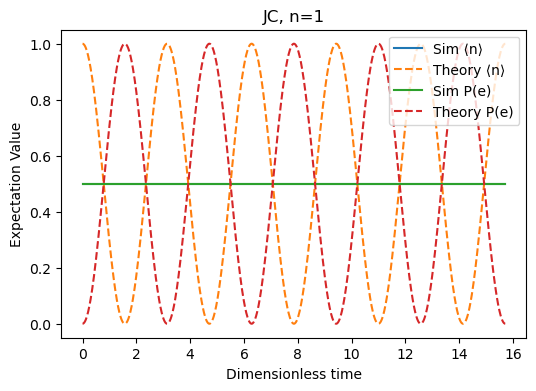

===== DEBUG for n = 2 =====
 Overlap(psi_n_g, |n,g>)     = (1+0j)
 Overlap(psi_n_e, |n-1,e>)   = (1+0j)
 Norm(|n,g> + |n-1,e>)      = 1.4142135623730951
 Final psi0 norm             = 1.0
 n=2, Omega_n=2.828, T_R=2.221

 First 5 photon-number values = [1.5 1.5 1.5 1.5 1.5]
 Last  5 photon-number values = [1.5 1.5 1.5 1.5 1.5]
 First 5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5]
 Last  5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5] 



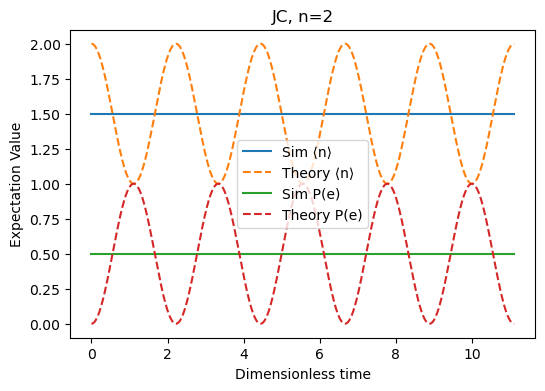

===== DEBUG for n = 3 =====
 Overlap(psi_n_g, |n,g>)     = (1+0j)
 Overlap(psi_n_e, |n-1,e>)   = (1+0j)
 Norm(|n,g> + |n-1,e>)      = 1.4142135623730951
 Final psi0 norm             = 1.0
 n=3, Omega_n=3.464, T_R=1.814

 First 5 photon-number values = [2.5 2.5 2.5 2.5 2.5]
 Last  5 photon-number values = [2.5 2.5 2.5 2.5 2.5]
 First 5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5]
 Last  5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5] 



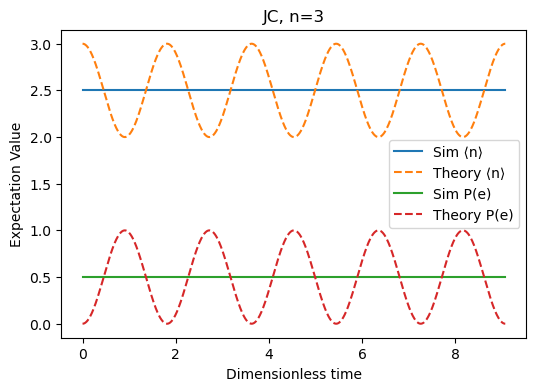

===== DEBUG for n = 4 =====
 Overlap(psi_n_g, |n,g>)     = (1+0j)
 Overlap(psi_n_e, |n-1,e>)   = (1+0j)
 Norm(|n,g> + |n-1,e>)      = 1.4142135623730951
 Final psi0 norm             = 1.0
 n=4, Omega_n=4.000, T_R=1.571

 First 5 photon-number values = [3.5 3.5 3.5 3.5 3.5]
 Last  5 photon-number values = [3.5 3.5 3.5 3.5 3.5]
 First 5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5]
 Last  5 excited-state vals   = [0.5 0.5 0.5 0.5 0.5] 



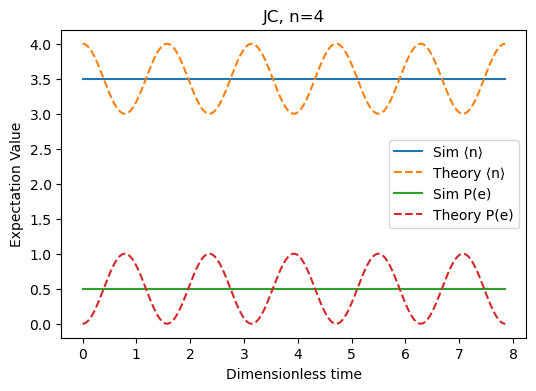

In [61]:
# Correct behavior of a stationary dressed eigenstate in the resonant Jaynes–Cummings model

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

###############################################################################
# Jaynes-Cummings validation code (QuTiP conventions):
#   basis(2, 0) = |e>, basis(2, 1) = |g>
###############################################################################

# -----------------------------------------------------------------------------
# 1) Physical parameters (dimensionless for clarity here)
# -----------------------------------------------------------------------------
wc = 2 * np.pi  # Suppose "ω_c = 2π"  => dimensionless frequency is 1
wa = 2 * np.pi  # Suppose "ω_a = 2π"  => wa/wc = 1
g  = 2 * np.pi  # Suppose "g   = 2π"  => dimensionless coupling ~ 1

# -----------------------------------------------------------------------------
# 2) Convert to dimensionless
# -----------------------------------------------------------------------------
g_eff     = g / wc
delta_eff = (wa - wc) / wc  # should be 0 if wa == wc
wa_over_wc = wa / wc

# -----------------------------------------------------------------------------
# 3) Hilbert space dimension + operators
# -----------------------------------------------------------------------------
n_cavity = 50  # truncated Fock space

a       = tensor(destroy(n_cavity), qeye(2))
adag    = a.dag()
num_cav = adag * a

sm = tensor(qeye(n_cavity), sigmam())
sp = tensor(qeye(n_cavity), sigmap())
sz = tensor(qeye(n_cavity), sigmaz())

# -----------------------------------------------------------------------------
# 4) Full dimensionless JC Hamiltonian
# -----------------------------------------------------------------------------
H_cavity = num_cav
H_atom   = 0.5 * wa_over_wc * sz   # factor wa/wc if they're not equal
H_int    = g_eff * (a*sp + adag*sm)

H = H_cavity + H_atom + H_int

# -----------------------------------------------------------------------------
# 5) Debug: verify lowering operator
# -----------------------------------------------------------------------------
e_ket = basis(2, 0)  # |e>
g_ket = basis(2, 1)  # |g>

print("DEBUG: sigmam() acting on |e> =>", (sigmam() * e_ket).full())
print("DEBUG: sigmam() acting on |g> =>", (sigmam() * g_ket).full(), "\n")

# -----------------------------------------------------------------------------
# 6) Test various rungs n
# -----------------------------------------------------------------------------
n_list = [1, 2, 3, 4]
n_steps = 1000  # can reduce a bit for quick prints

for n in n_list:
    # Construct rung-n initial state
    if n == 0:
        psi0 = tensor(fock(n_cavity, 0), g_ket)
    else:
        psi_n_g = tensor(fock(n_cavity, n),   g_ket)  # |n,g>
        psi_n_e = tensor(fock(n_cavity, n-1), e_ket)  # |n-1,e>
        psi0    = (psi_n_g + psi_n_e).unit()

    print(f"===== DEBUG for n = {n} =====")
    if n > 0:
        print(" Overlap(psi_n_g, |n,g>)     =", 
              psi_n_g.overlap(tensor(fock(n_cavity, n), g_ket)))
        print(" Overlap(psi_n_e, |n-1,e>)   =", 
              psi_n_e.overlap(tensor(fock(n_cavity, n-1), e_ket)))
        print(" Norm(|n,g> + |n-1,e>)      =", (psi_n_g + psi_n_e).norm())
    print(" Final psi0 norm             =", psi0.norm())

    # Rabi frequency + times
    Omega_n = 2 * g_eff * np.sqrt(n) if n>0 else 0.0
    T_R = 2*np.pi / Omega_n if Omega_n!=0 else 1.0
    print(f" n={n}, Omega_n={Omega_n:.3f}, T_R={T_R:.3f}\n")

    t_max = 5*T_R
    tlist = np.linspace(0, t_max, n_steps)

    # Evolve
    e_proj = tensor(qeye(n_cavity), e_ket*e_ket.dag())
    result = mesolve(H, psi0, tlist, [], [num_cav, e_proj])

    # Print first/last few points of the evolution 
    print(" First 5 photon-number values =", result.expect[0][:5])
    print(" Last  5 photon-number values =", result.expect[0][-5:])
    print(" First 5 excited-state vals   =", result.expect[1][:5])
    print(" Last  5 excited-state vals   =", result.expect[1][-5:], "\n")

    # Theoretical predictions
    if n>0:
        P_e_th   = np.sin(Omega_n*tlist/2)**2
        n_cav_th = n*np.cos(Omega_n*tlist/2)**2 + (n-1)*np.sin(Omega_n*tlist/2)**2
    else:
        P_e_th   = np.zeros_like(tlist)
        n_cav_th = np.zeros_like(tlist)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(tlist, result.expect[0], label="Sim ⟨n⟩")
    plt.plot(tlist, n_cav_th, '--',   label="Theory ⟨n⟩")
    plt.plot(tlist, result.expect[1], label="Sim P(e)")
    plt.plot(tlist, P_e_th,     '--', label="Theory P(e)")
    plt.title(f"JC, n={n}")
    plt.xlabel("Dimensionless time")
    plt.ylabel("Expectation Value")
    plt.legend()
    plt.show()


DEBUG: sigmam() acting on |e> => [[0.+0.j]
 [1.+0.j]]
DEBUG: sigmam() acting on |g> => [[0.+0.j]
 [0.+0.j]] 

===== DEBUG for n = 1 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=1, Omega_n=2.000, T_R=3.142

 First 5 photon-number values = [1.         0.99975279 0.99901139 0.99777654 0.99604946]
 Last  5 photon-number values = [0.99605367 0.9977797  0.99901349 0.99975384 0.99999999]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395054]
 Last  5 excited-state vals   = [3.94633025e-03 2.22030113e-03 9.86505890e-04 2.46163570e-04
 6.65328288e-09] 



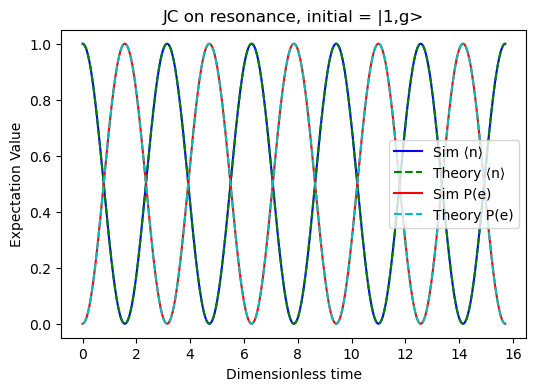

===== DEBUG for n = 2 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=2, Omega_n=2.828, T_R=2.221

 First 5 photon-number values = [2.         1.99975279 1.99901139 1.99777654 1.99604947]
 Last  5 photon-number values = [1.99605581 1.99778131 1.99901457 1.99975438 1.99999999]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395053]
 Last  5 excited-state vals   = [3.94419286e-03 2.21869275e-03 9.85431144e-04 2.45624697e-04
 5.50556671e-09] 



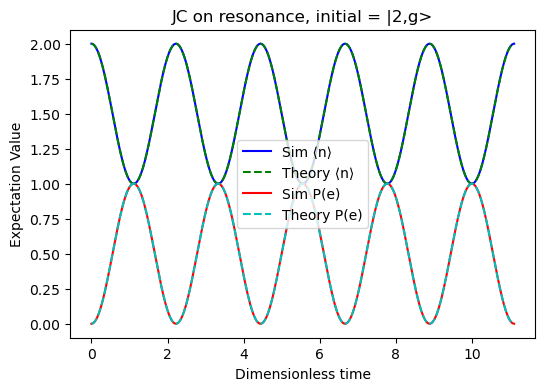

===== DEBUG for n = 3 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=3, Omega_n=3.464, T_R=1.814

 First 5 photon-number values = [3.         2.99975279 2.99901139 2.99777654 2.99604947]
 Last  5 photon-number values = [2.99604678 2.99777453 2.99901005 2.99975211 3.        ]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395053]
 Last  5 excited-state vals   = [3.95321685e-03 2.22546969e-03 9.89953127e-04 2.47886014e-04
 3.03804491e-09] 



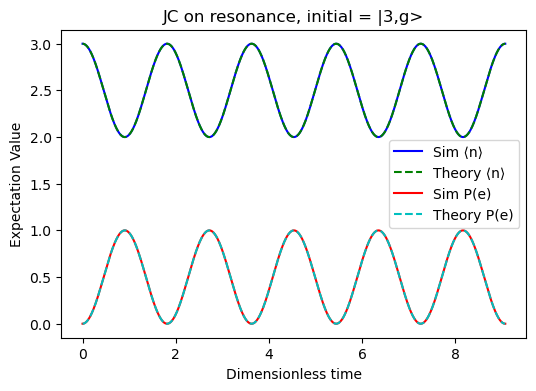

===== DEBUG for n = 4 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=4, Omega_n=4.000, T_R=1.571

 First 5 photon-number values = [4.         3.99975279 3.99901139 3.99777654 3.99604946]
 Last  5 photon-number values = [3.99604733 3.99777494 3.99901032 3.99975225 4.        ]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395054]
 Last  5 excited-state vals   = [3.95266927e-03 2.22506127e-03 9.89680429e-04 2.47749181e-04
 1.32716630e-09] 



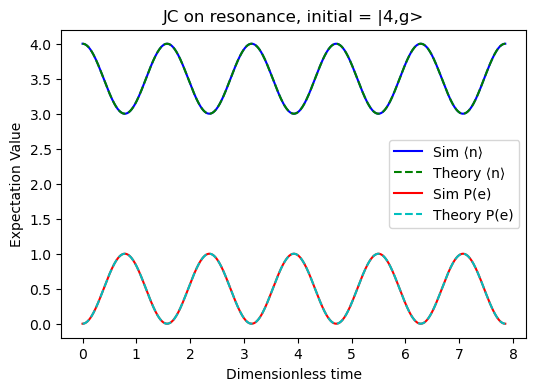

===== DEBUG for n = 5 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=5, Omega_n=4.472, T_R=1.405

 First 5 photon-number values = [5.         4.99975279 4.99901139 4.99777654 4.99604946]
 Last  5 photon-number values = [4.9960507  4.99777745 4.99901199 4.99975309 5.        ]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395054]
 Last  5 excited-state vals   = [3.94930221e-03 2.22254767e-03 9.88006646e-04 2.46912226e-04
 3.18058338e-09] 



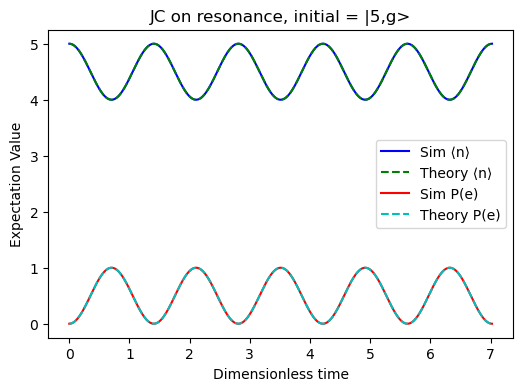

===== DEBUG for n = 6 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=6, Omega_n=4.899, T_R=1.283

 First 5 photon-number values = [6.         5.99975279 5.99901139 5.99777654 5.99604946]
 Last  5 photon-number values = [5.99604269 5.99777146 5.99900799 5.99975108 5.99999999]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395054]
 Last  5 excited-state vals   = [3.95730704e-03 2.22854109e-03 9.92006200e-04 2.48917391e-04
 5.52525700e-09] 



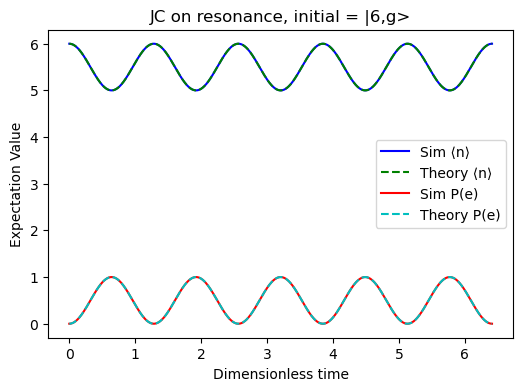

===== DEBUG for n = 7 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=7, Omega_n=5.292, T_R=1.187

 First 5 photon-number values = [7.         6.99975279 6.99901139 6.99777654 6.99604946]
 Last  5 photon-number values = [6.99605464 6.9977804  6.99901395 6.99975406 6.99999998]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395054]
 Last  5 excited-state vals   = [3.94536212e-03 2.21960126e-03 9.86048105e-04 2.45943617e-04
 1.65816323e-08] 



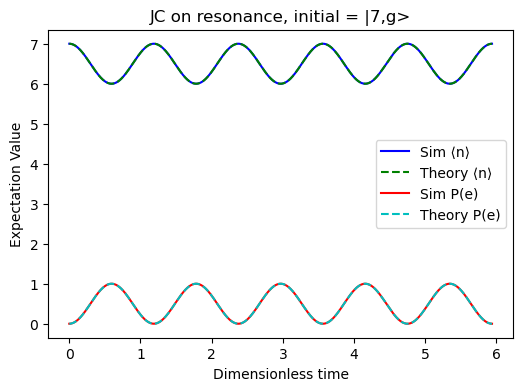

===== DEBUG for n = 8 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Final psi0 norm         = 1.0
 n=8, Omega_n=5.657, T_R=1.111

 First 5 photon-number values = [8.         7.99975279 7.99901139 7.99777654 7.99604946]
 Last  5 photon-number values = [7.9960441  7.99777252 7.9990087  7.99975144 8.        ]
 First 5 excited-state vals   = [0.         0.00024721 0.00098861 0.00222346 0.00395054]
 Last  5 excited-state vals   = [3.95589881e-03 2.22748497e-03 9.91299001e-04 2.48560066e-04
 4.45421917e-09] 



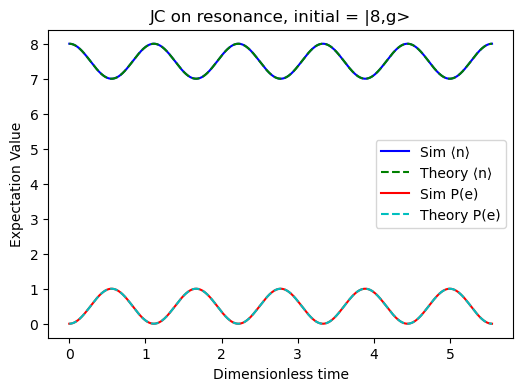

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

###############################################################################
# Jaynes-Cummings code (QuTiP conventions):
#   basis(2, 0) = |e>, basis(2, 1) = |g>
#
# We choose dimensionless units here by setting:
#     ω_c = 2π  (makes one cycle = 1 time unit)
#     ω_a = 2π  => on-resonance (wa/wc = 1)
#     g   = 2π  => dimensionless coupling g_eff = g/wc = 1
#
# Importantly, we now start in the BARE state |n,g>, NOT the dressed state.
###############################################################################

# -----------------------------------------------------------------------------
# 1) "Physical" parameters in dimensionless form
# -----------------------------------------------------------------------------
wc = 2 * np.pi   # sets "1 cycle" = 1 time unit
wa = 2 * np.pi   # same => on resonance (wa/wc = 1)
g  = 2 * np.pi   # same => dimensionless coupling ~ 1

# -----------------------------------------------------------------------------
# 2) Coupling ratios
# -----------------------------------------------------------------------------
g_eff     = g / wc                  # = 1
delta_eff = (wa - wc) / wc          # = 0 on resonance
wa_over_wc = wa / wc                # = 1

# -----------------------------------------------------------------------------
# 3) Hilbert space dimension + operators
# -----------------------------------------------------------------------------
n_cavity = 50
a       = tensor(destroy(n_cavity), qeye(2))
adag    = a.dag()
num_cav = adag * a

# Two-level operators
sm = tensor(qeye(n_cavity), sigmam())
sp = tensor(qeye(n_cavity), sigmap())
sz = tensor(qeye(n_cavity), sigmaz())

# -----------------------------------------------------------------------------
# 4) Full dimensionless JC Hamiltonian
# -----------------------------------------------------------------------------
H_cavity = num_cav
H_atom   = 0.5 * wa_over_wc * sz         # = 0.5 * 1.0 * sz on resonance
H_int    = g_eff * (a*sp + adag*sm)      # = (a sp + a† sm)

H = H_cavity + H_atom + H_int

# -----------------------------------------------------------------------------
# 5) Debug: check lowering operator action
# -----------------------------------------------------------------------------
e_ket = basis(2, 0)  # |e>
g_ket = basis(2, 1)  # |g>

print("DEBUG: sigmam() acting on |e> =>", (sigmam() * e_ket).full())
print("DEBUG: sigmam() acting on |g> =>", (sigmam() * g_ket).full(), "\n")

# -----------------------------------------------------------------------------
# 6) Test multiple rungs (1 to 8) 
#    This time, we start in the BARE state |n,g>, which DOES evolve non-trivially
# -----------------------------------------------------------------------------
n_list = [1, 2, 3, 4, 5, 6, 7, 8]
n_steps = 1000

for n in n_list:
    # -------------------------------------------------------------------------
    # Construct the bare initial state |n,g>
    # -------------------------------------------------------------------------
    psi_n_g = tensor(fock(n_cavity, n), g_ket)  # |n,g>
    psi0 = psi_n_g  # no superposition => full Rabi swings

    print(f"===== DEBUG for n = {n} =====")
    print(" Overlap(psi_n_g, |n,g>) =", 
          psi_n_g.overlap(tensor(fock(n_cavity, n), g_ket)))
    print(" Final psi0 norm         =", psi0.norm())

    # -------------------------------------------------------------------------
    # 7) The rung-n Rabi frequency and time steps
    #
    #    On resonance, rung-n has splitting = Ω_n = 2*g_eff*sqrt(n).
    #    If initial state is |n,g>, it swaps into |n-1,e> and back.
    # -------------------------------------------------------------------------
    Omega_n = 2 * g_eff * np.sqrt(n)
    T_R     = 2*np.pi / Omega_n  # one full Rabi period
    print(f" n={n}, Omega_n={Omega_n:.3f}, T_R={T_R:.3f}\n")

    # Simulate for 5 Rabi cycles
    t_max = 5*T_R
    tlist = np.linspace(0, t_max, n_steps)

    # -------------------------------------------------------------------------
    # 8) Solve
    # -------------------------------------------------------------------------
    e_proj = tensor(qeye(n_cavity), e_ket*e_ket.dag())
    result = mesolve(H, psi0, tlist, [], [num_cav, e_proj])

    # Just to confirm the system changes:
    print(" First 5 photon-number values =", result.expect[0][:5])
    print(" Last  5 photon-number values =", result.expect[0][-5:])
    print(" First 5 excited-state vals   =", result.expect[1][:5])
    print(" Last  5 excited-state vals   =", result.expect[1][-5:], "\n")

    # -------------------------------------------------------------------------
    # 9) Theoretical predictions for starting in |n,g> on rung-n
    #    Probability to be in |n-1,e> is sin²(Ω_n t / 2)
    #    => P(e)(t) = sin²(Ω_n t / 2)
    #       ⟨n⟩(t)  = n cos²(...) + (n-1) sin²(...)
    # -------------------------------------------------------------------------
    P_e_th = np.sin(Omega_n*tlist/2.0)**2
    n_cav_th = (n     * np.cos(Omega_n*tlist/2.0)**2
              + (n-1) * np.sin(Omega_n*tlist/2.0)**2)

    # -------------------------------------------------------------------------
    # 10) Plot
    # -------------------------------------------------------------------------
    plt.figure(figsize=(6,4))
    plt.plot(tlist, result.expect[0], 'b', label="Sim ⟨n⟩")
    plt.plot(tlist, n_cav_th,         'g--',label="Theory ⟨n⟩")
    plt.plot(tlist, result.expect[1], 'r', label="Sim P(e)")
    plt.plot(tlist, P_e_th,           'c--',label="Theory P(e)")
    plt.title(f"JC on resonance, initial = |{n},g>")
    plt.xlabel("Dimensionless time")
    plt.ylabel("Expectation Value")
    plt.legend()
    plt.show()


DEBUG: sigmam() acting on |e> => [[0.+0.j]
 [1.+0.j]]
DEBUG: sigmam() acting on |g> => [[0.+0.j]
 [0.+0.j]] 


===== DEBUG for n=1 with alpha=2, beta=1 superposition =====
 Overlap with |n,g>    = (0.8944271909999159+0j)
 Overlap with |n-1,e>  = (0.4472135954999579+0j)
 Norm of raw superposn = 2.23606797749979
 Final psi0 norm       = 1.0
 Rung 1: Omega_n=2.000, T_R=3.142
 Photon # first 5 = [0.8        0.79985187 0.79940704 0.79866614 0.79762989]
 Photon # last  5 = [0.79774507 0.79877952 0.79951856 0.79996145 0.80010775]
 P(e)    first 5 = [0.2        0.20014813 0.20059296 0.20133386 0.20237011]
 P(e)    last  5 = [0.20225493 0.20122048 0.20048144 0.20003855 0.19989225] 



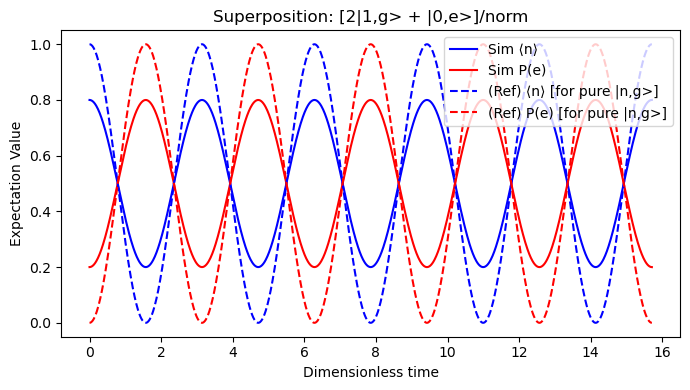


===== DEBUG for n=2 with alpha=2, beta=1 superposition =====
 Overlap with |n,g>    = (0.8944271909999159+0j)
 Overlap with |n-1,e>  = (0.4472135954999579+0j)
 Norm of raw superposn = 2.23606797749979
 Final psi0 norm       = 1.0
 Rung 2: Omega_n=2.828, T_R=2.221
 Photon # first 5 = [1.8        1.7998519  1.79940705 1.79866614 1.79762986]
 Photon # last  5 = [1.79778512 1.79881934 1.79955809 1.80000063 1.80014647]
 P(e)    first 5 = [0.2        0.2001481  0.20059295 0.20133386 0.20237014]
 P(e)    last  5 = [0.20221488 0.20118066 0.20044191 0.19999937 0.19985353] 



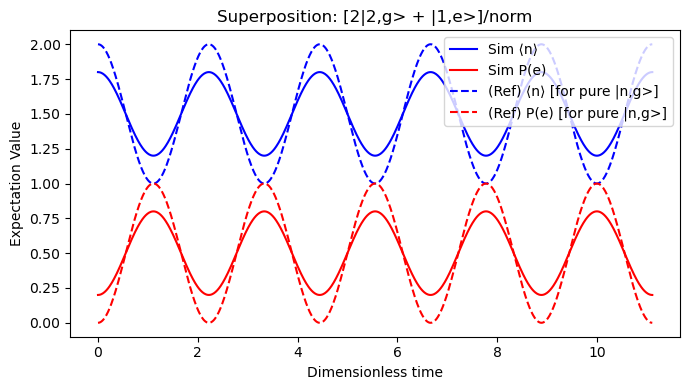


===== DEBUG for n=3 with alpha=2, beta=1 superposition =====
 Overlap with |n,g>    = (0.8944271909999159+0j)
 Overlap with |n-1,e>  = (0.4472135954999579+0j)
 Norm of raw superposn = 2.23606797749979
 Final psi0 norm       = 1.0
 Rung 3: Omega_n=3.464, T_R=1.814
 Photon # first 5 = [2.8        2.79985232 2.79940747 2.79866655 2.79763021]
 Photon # last  5 = [2.79779194 2.79882583 2.79956426 2.80000654 2.80015222]
 P(e)    first 5 = [0.2        0.20014768 0.20059253 0.20133345 0.20236979]
 P(e)    last  5 = [0.20220806 0.20117417 0.20043574 0.19999346 0.19984778] 



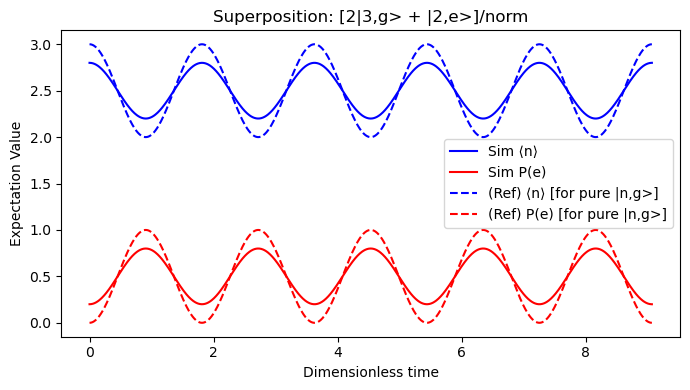


===== DEBUG for n=4 with alpha=2, beta=1 superposition =====
 Overlap with |n,g>    = (0.8944271909999159+0j)
 Overlap with |n-1,e>  = (0.4472135954999579+0j)
 Norm of raw superposn = 2.23606797749979
 Final psi0 norm       = 1.0
 Rung 4: Omega_n=4.000, T_R=1.571
 Photon # first 5 = [3.8        3.79985229 3.79940744 3.7986665  3.79763016]
 Photon # last  5 = [3.79768418 3.79871966 3.79945977 3.79990379 3.80005124]
 P(e)    first 5 = [0.2        0.20014771 0.20059256 0.2013335  0.20236984]
 P(e)    last  5 = [0.20231582 0.20128034 0.20054023 0.20009621 0.19994876] 



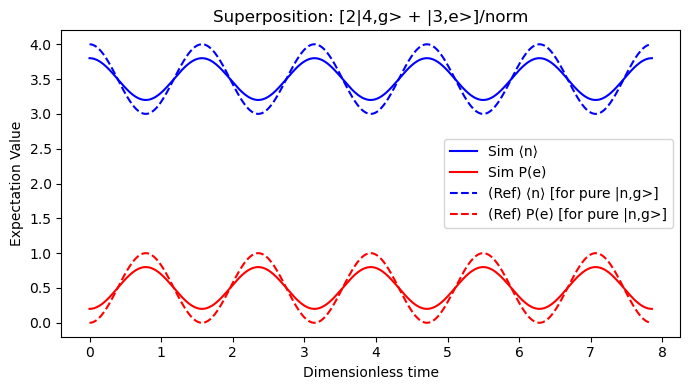


===== DEBUG for n=5 with alpha=2, beta=1 superposition =====
 Overlap with |n,g>    = (0.8944271909999159+0j)
 Overlap with |n-1,e>  = (0.4472135954999579+0j)
 Norm of raw superposn = 2.23606797749979
 Final psi0 norm       = 1.0
 Rung 5: Omega_n=4.472, T_R=1.405
 Photon # first 5 = [4.8        4.79985227 4.79940742 4.79866645 4.79763011]
 Photon # last  5 = [4.7978715  4.79890455 4.79964194 4.80008314 4.80022769]
 P(e)    first 5 = [0.2        0.20014773 0.20059258 0.20133355 0.20236989]
 P(e)    last  5 = [0.2021285  0.20109545 0.20035806 0.19991686 0.19977231] 



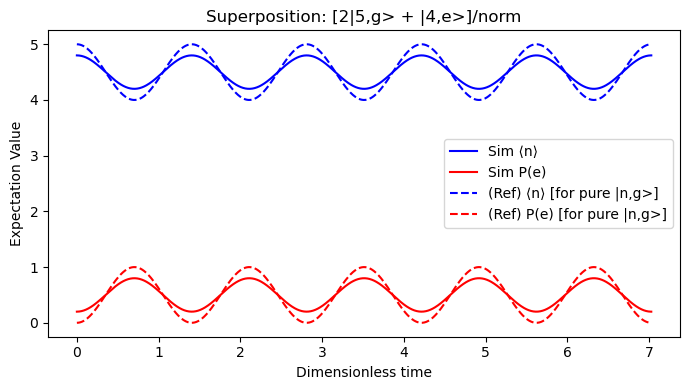

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

###############################################################################
# Jaynes-Cummings code (QuTiP conventions):
#   basis(2, 0) = |e>, basis(2, 1) = |g>
#
# We choose dimensionless units by setting:
#   ω_c = 2π   =>  1 cycle = 1 time unit
#   ω_a = 2π   =>  on resonance (wa/wc = 1)
#   g   = 2π   =>  dimensionless coupling g_eff = 1
###############################################################################

# -----------------------------------------------------------------------------
# 1) "Physical" parameters in dimensionless form
# -----------------------------------------------------------------------------
wc = 2 * np.pi   # sets "1 cycle" = 1 time unit
wa = 2 * np.pi   # same => on resonance
g  = 2 * np.pi   # dimensionless coupling ~ 1

# -----------------------------------------------------------------------------
# 2) Coupling ratios
# -----------------------------------------------------------------------------
g_eff     = g / wc             # = 1
delta_eff = (wa - wc) / wc     # = 0 if wa == wc
wa_over_wc = wa / wc           # = 1

# -----------------------------------------------------------------------------
# 3) Hilbert space dimension + operators
# -----------------------------------------------------------------------------
n_cavity = 40
a       = tensor(destroy(n_cavity), qeye(2))
adag    = a.dag()
num_cav = adag * a

sm = tensor(qeye(n_cavity), sigmam())
sp = tensor(qeye(n_cavity), sigmap())
sz = tensor(qeye(n_cavity), sigmaz())

# -----------------------------------------------------------------------------
# 4) Full dimensionless JC Hamiltonian
# -----------------------------------------------------------------------------
H_cavity = num_cav
H_atom   = 0.5 * wa_over_wc * sz     # 0.5 * 1.0 * sz on resonance
H_int    = g_eff * (a*sp + adag*sm)  # = (a sp + a† sm)

H = H_cavity + H_atom + H_int

# -----------------------------------------------------------------------------
# 5) Debug: check lowering operator action
# -----------------------------------------------------------------------------
e_ket = basis(2, 0)  # |e>
g_ket = basis(2, 1)  # |g>

print("DEBUG: sigmam() acting on |e> =>", (sigmam() * e_ket).full())
print("DEBUG: sigmam() acting on |g> =>", (sigmam() * g_ket).full(), "\n")

# -----------------------------------------------------------------------------
# 6) Let's explore multiple rungs (n=1..5), but with a superposition
#    that is NOT the perfectly symmetric (|n,g> + |n-1,e>)/√2.
# -----------------------------------------------------------------------------
n_list = [1, 2, 3, 4, 5]
n_steps = 1000

for n in n_list:

    # -------------------------------------------------------------------------
    # Define a superposition that is definitely not a 50/50 mix.
    # For instance: Psi(0) = (2|n,g> + 1|n-1,e>)/norm
    # -------------------------------------------------------------------------
    if n > 0:
        alpha = 2.0
        beta  = 1.0
        psi_n_g = tensor(fock(n_cavity, n), g_ket)      # |n,g>
        psi_n_e = tensor(fock(n_cavity, n-1), e_ket)    # |n-1,e>
        raw_superposition = alpha * psi_n_g + beta * psi_n_e
        psi0 = raw_superposition.unit()
    else:
        # If n=0, there's no |n-1,e>. We'll skip that trivial rung here.
        continue

    # -------------------------------------------------------------------------
    # Debug info about initial state
    # -------------------------------------------------------------------------
    print(f"\n===== DEBUG for n={n} with alpha=2, beta=1 superposition =====")
    print(" Overlap with |n,g>    =", psi0.overlap(psi_n_g))
    print(" Overlap with |n-1,e>  =", psi0.overlap(psi_n_e))
    print(" Norm of raw superposn =", raw_superposition.norm())
    print(" Final psi0 norm       =", psi0.norm())

    # Rabi frequency for rung-n
    Omega_n = 2 * g_eff * np.sqrt(n)
    T_R     = 2*np.pi / Omega_n  # one full Rabi period
    print(f" Rung {n}: Omega_n={Omega_n:.3f}, T_R={T_R:.3f}")

    # -------------------------------------------------------------------------
    # 7) Solve time evolution for ~5 Rabi cycles
    # -------------------------------------------------------------------------
    t_max = 5 * T_R
    tlist = np.linspace(0, t_max, n_steps)

    e_proj = tensor(qeye(n_cavity), e_ket*e_ket.dag())
    result = mesolve(H, psi0, tlist, [], [num_cav, e_proj])

    # Let's see some numeric values to confirm change
    print(" Photon # first 5 =", result.expect[0][:5])
    print(" Photon # last  5 =", result.expect[0][-5:])
    print(" P(e)    first 5 =", result.expect[1][:5])
    print(" P(e)    last  5 =", result.expect[1][-5:], "\n")

    # -------------------------------------------------------------------------
    # 8) Theoretical predictions for a general superposition in a rung-2D subspace
    #
    #   The subspace is spanned by {|n,g>, |n-1,e>}.
    #   We can get exact solutions, but let's do so
    #   for clarity by diagonalizing that 2x2 block or
    #   simply trust mesolve + check that we see a 'beating'
    #   with frequency Ω_n in the population exchange.
    #
    #   We'll just skip an explicit "superposition formula" here,
    #   because it's not a pure sinusoid as in the 50/50 case.
    #
    #   For reference, the Rabi frequency is still Ω_n,
    #   but the amplitude of photon or atomic oscillations
    #   depends on alpha/beta.
    # -------------------------------------------------------------------------

    # We'll just keep the "bare rung" formula for reference,
    # but it won't match exactly because alpha != beta. 
    # That formula is strictly for starting in |n,g> alone:
    P_e_reference = np.sin(Omega_n * tlist / 2.0)**2
    n_cav_reference = (n     * np.cos(Omega_n * tlist / 2.0)**2 +
                      (n-1) * np.sin(Omega_n * tlist / 2.0)**2)

    # -------------------------------------------------------------------------
    # 9) Plot results
    # -------------------------------------------------------------------------
    plt.figure(figsize=(7,4))
    plt.plot(tlist, result.expect[0], 'b',  label="Sim ⟨n⟩")
    plt.plot(tlist, result.expect[1], 'r',  label="Sim P(e)")
    plt.plot(tlist, n_cav_reference, 'b--', label="(Ref) ⟨n⟩ [for pure |n,g>]")
    plt.plot(tlist, P_e_reference,   'r--', label="(Ref) P(e) [for pure |n,g>]")

    plt.title(f"Superposition: [2|{n},g> + |{n-1},e>]/norm")
    plt.xlabel("Dimensionless time")
    plt.ylabel("Expectation Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [72]:
##### Driven JCM

DEBUG: sigmam() acting on |e> => [[0.+0.j]
 [1.+0.j]]
DEBUG: sigmam() acting on |g> => [[0.+0.j]
 [0.+0.j]] 

===== DEBUG for n=1 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 1: Omega_n=2.000, T_R=3.142
 Photon # first 5 = [1.         0.99994072 0.99976291 0.9994666  0.99905187]
 Photon # last  5 = [0.79371444 0.79985021 0.80592282 0.81193078 0.81787263]
 P(e)     first 5 = [0.00000000e+00 6.17455255e-05 2.46967310e-04 5.55620969e-04
 9.87632544e-04]
 P(e)     last  5 = [0.2283558  0.22203728 0.21578786 0.20960907 0.20350245] 



/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


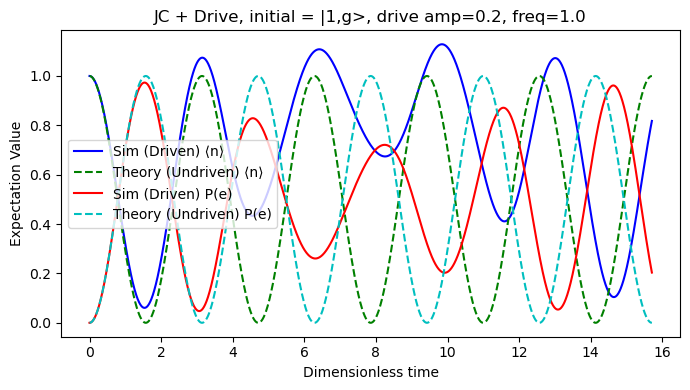

===== DEBUG for n=2 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 2: Omega_n=2.828, T_R=2.221
 Photon # first 5 = [2.         1.99993949 1.99975797 1.99945549 1.99903213]
 Photon # last  5 = [2.36822427 2.36813753 2.36805026 2.36796254 2.36787444]
 P(e)     first 5 = [0.00000000e+00 6.17454962e-05 2.46966849e-04 5.55618633e-04
 9.87625178e-04]
 P(e)     last  5 = [0.4530118  0.45311108 0.4532118  0.45331391 0.45341733] 



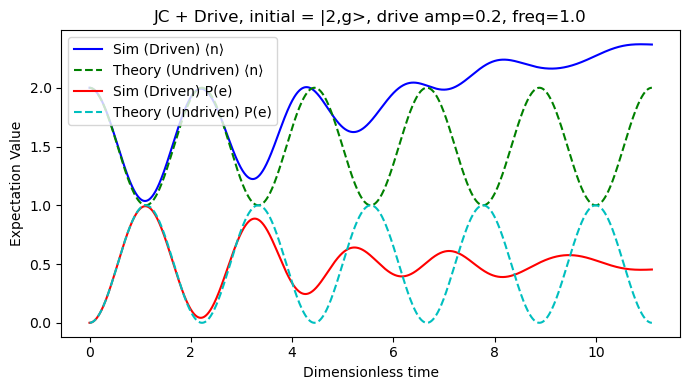

===== DEBUG for n=3 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 3: Omega_n=3.464, T_R=1.814
 Photon # first 5 = [3.         2.99993908 2.99975633 2.99945179 2.99902555]
 Photon # last  5 = [3.03505174 3.03495589 3.03490437 3.0348973  3.03493482]
 P(e)     first 5 = [0.00000000e+00 6.17454902e-05 2.46966760e-04 5.55618177e-04
 9.87623773e-04]
 P(e)     last  5 = [0.68628295 0.68731863 0.68831371 0.68926804 0.69018146] 



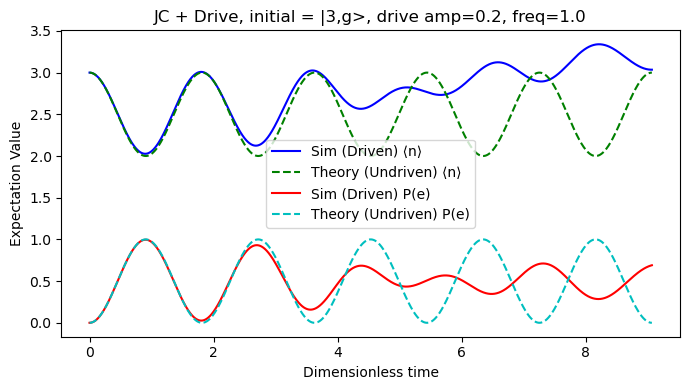

===== DEBUG for n=4 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 4: Omega_n=4.000, T_R=1.571
 Photon # first 5 = [4.         3.99993887 3.9997555  3.99944994 3.99902225]
 Photon # last  5 = [3.95552431 3.95605102 3.9566251  3.95724631 3.95791436]
 P(e)     first 5 = [0.00000000e+00 6.17454878e-05 2.46966724e-04 5.55618002e-04
 9.87623275e-04]
 P(e)     last  5 = [0.68017992 0.67965502 0.67908217 0.67846168 0.67779387] 



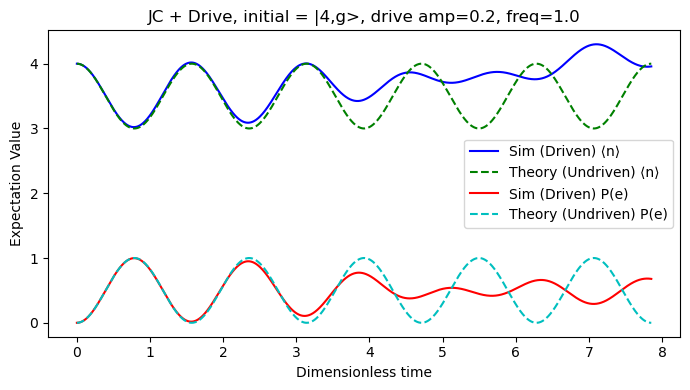

===== DEBUG for n=5 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 5: Omega_n=4.472, T_R=1.405
 Photon # first 5 = [5.         4.99993875 4.99975501 4.99944883 4.99902028]
 Photon # last  5 = [4.87634159 4.87706729 4.87784598 4.87867758 4.87956196]
 P(e)     first 5 = [0.00000000e+00 6.17454865e-05 2.46966704e-04 5.55617911e-04
 9.87623062e-04]
 P(e)     last  5 = [0.70135362 0.70123104 0.70105238 0.70081777 0.7005273 ] 



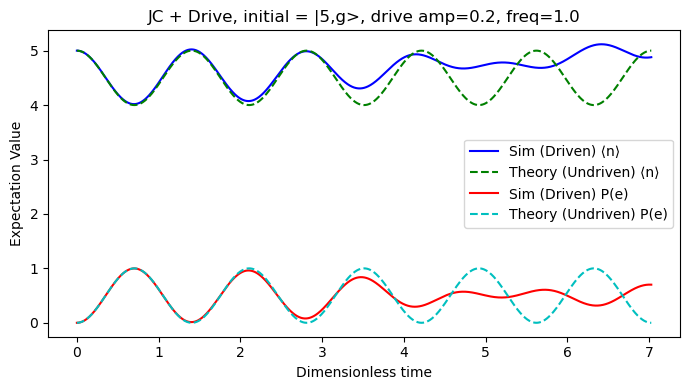

===== DEBUG for n=6 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 6: Omega_n=4.899, T_R=1.283
 Photon # first 5 = [6.         5.99993867 5.99975468 5.99944809 5.99901896]
 Photon # last  5 = [5.74741359 5.7478602  5.74835882 5.74890962 5.74951276]
 P(e)     first 5 = [0.00000000e+00 6.17454857e-05 2.46966690e-04 5.55617856e-04
 9.87622972e-04]
 P(e)     last  5 = [0.69187399 0.69226336 0.69260058 0.69288548 0.69311787] 



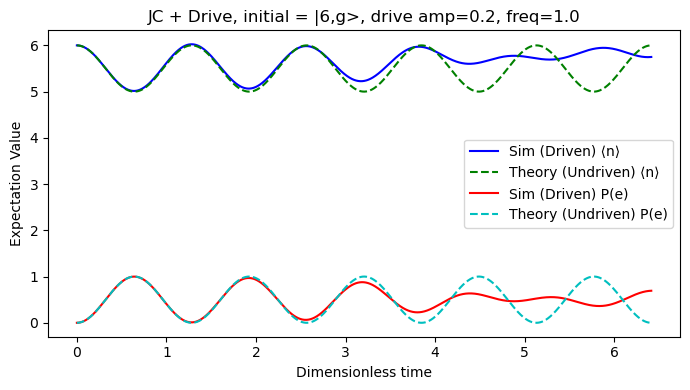

===== DEBUG for n=7 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 7: Omega_n=5.292, T_R=1.187
 Photon # first 5 = [7.         6.99993861 6.99975444 6.99944756 6.99901802]
 Photon # last  5 = [6.66884486 6.66879022 6.66877854 6.66881013 6.6688853 ]
 P(e)     first 5 = [0.00000000e+00 6.17454851e-05 2.46966678e-04 5.55617820e-04
 9.87622945e-04]
 P(e)     last  5 = [0.65635979 0.65700874 0.65761631 0.65818218 0.65870602] 



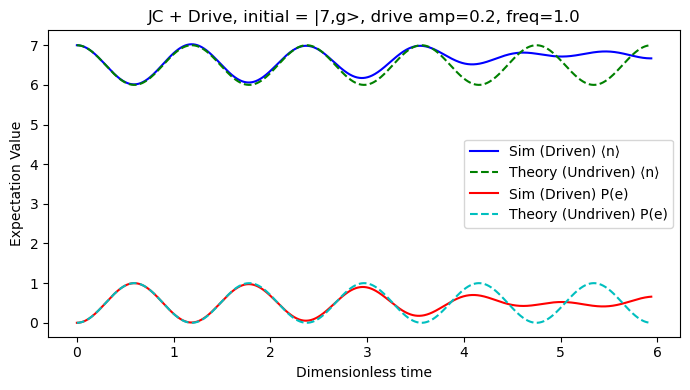

===== DEBUG for n=8 =====
 Overlap(psi_n_g, |n,g>) = (1+0j)
 Norm of psi0 = 1.0
 Rung 8: Omega_n=5.657, T_R=1.111
 Photon # first 5 = [8.         7.99993856 7.99975427 7.99944716 7.99901732]
 Photon # last  5 = [7.65380541 7.65333443 7.65289429 7.65248538 7.65210807]
 P(e)     first 5 = [0.00000000e+00 6.17454846e-05 2.46966668e-04 5.55617797e-04
 9.87622955e-04]
 P(e)     last  5 = [0.61135347 0.61211501 0.61284742 0.61355029 0.61422324] 



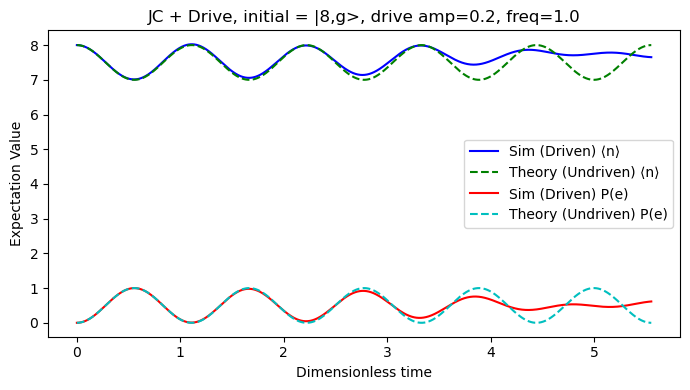

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

###############################################################################
# Jaynes-Cummings code (QuTiP conventions):
#   basis(2, 0) = |e>, basis(2, 1) = |g>
#
# We choose dimensionless units by setting:
#   ω_c = 2π  => 1 cycle = 1 time unit
#   ω_a = 2π  => on resonance (wa/wc = 1)
#   g   = 2π  => dimensionless coupling g_eff = 1
###############################################################################

# 1) Dimensionless frequencies
wc = 2 * np.pi   # sets "1 cycle" = 1 time unit
wa = 2 * np.pi   # same => on resonance
g  = 2 * np.pi   # => dimensionless coupling ~ 1

g_eff = g / wc   # = 1
wa_over_wc = wa / wc  # = 1 => on resonance

# 2) Hilbert space and bare JC Hamiltonian
n_cavity = 50
a    = tensor(destroy(n_cavity), qeye(2))
adag = a.dag()
num_cav = adag * a

sm = tensor(qeye(n_cavity), sigmam())
sp = tensor(qeye(n_cavity), sigmap())
sz = tensor(qeye(n_cavity), sigmaz())

H_cavity = num_cav
H_atom   = 0.5 * wa_over_wc * sz            # = 0.5 * sz on resonance
H_int    = g_eff * (a * sp + adag * sm)     # standard JC coupling
H0 = H_cavity + H_atom + H_int

# 3) Add a drive on the cavity: H_drive = ε(t)*(a + a†).
#    We'll define ε(t)=ε0*cos(ω_d*t).  You can adjust amplitude/frequency as needed.
drive_ampl  = 0.2    # drive amplitude, dimensionless
drive_freq  = 1.0    # driving frequency, dimensionless (i.e. in units of ω_c=2π)
drive_op    = (a + adag)

def drive_func(t, args):
    """Time-dependent drive amplitude: ε0 * cos(ω_d * t)."""
    return drive_ampl * np.cos(drive_freq * t)

# Full time-dependent Hamiltonian list recognized by QuTiP:
#  The first element is the time-independent part H0
#  The second is [drive_op, drive_func], meaning drive_op * drive_func(t).
H_total = [H0, [drive_op, drive_func]]

# 4) Just some debug
e_ket = basis(2, 0)  # |e>
g_ket = basis(2, 1)  # |g>
print("DEBUG: sigmam() acting on |e> =>", (sigmam() * e_ket).full())
print("DEBUG: sigmam() acting on |g> =>", (sigmam() * g_ket).full(), "\n")

# 5) We will test multiple rung numbers n
n_list  = [1,2,3,4,5,6,7,8]
n_steps = 2000     # number of time points
solver  = 'mesolve'  # or 'sesolve' if no collapse operators

for n in n_list:
    # -------------------------------------------------------------------------
    # (A) Construct bare initial state: |n,g>
    # -------------------------------------------------------------------------
    psi_n_g = tensor(fock(n_cavity, n), g_ket)
    psi0    = psi_n_g

    print(f"===== DEBUG for n={n} =====")
    print(" Overlap(psi_n_g, |n,g>) =", psi_n_g.overlap(psi_n_g))
    print(" Norm of psi0 =", psi0.norm())

    # -------------------------------------------------------------------------
    # (B) The rung-n Rabi frequency (undriven formula).
    #     On resonance => Ω_n = 2*g_eff*sqrt(n). We use it for the "theory" lines.
    # -------------------------------------------------------------------------
    Omega_n = 2 * g_eff * np.sqrt(n)
    T_R     = 2*np.pi / Omega_n
    print(f" Rung {n}: Omega_n={Omega_n:.3f}, T_R={T_R:.3f}")

    # We'll simulate ~5 Rabi cycles if undriven, but the drive modifies things.
    t_max = 5 * T_R
    tlist = np.linspace(0, t_max, n_steps)

    # -------------------------------------------------------------------------
    # (C) Solve with the *driven* Hamiltonian
    #     Because we have no dissipation, we just pass empty c_ops.
    # -------------------------------------------------------------------------
    e_proj   = tensor(qeye(n_cavity), e_ket * e_ket.dag())
    result   = mesolve(H_total, psi0, tlist, [], [num_cav, e_proj], options=Options(store_states=False))

    # Let's just show first/last few data points
    print(" Photon # first 5 =", result.expect[0][:5])
    print(" Photon # last  5 =", result.expect[0][-5:])
    print(" P(e)     first 5 =", result.expect[1][:5])
    print(" P(e)     last  5 =", result.expect[1][-5:], "\n")

    # -------------------------------------------------------------------------
    # (D) "Undriven" Theoretical Predictions
    #     For initial = |n,g>, we *would* have if no drive:
    #        P(e)(t) = sin²(Ω_n * t/2)
    #        <n>(t)  = n cos²(...) + (n-1) sin²(...)
    # -------------------------------------------------------------------------
    P_e_undriven   = np.sin(Omega_n * tlist / 2.0)**2
    n_cav_undriven = (n     * np.cos(Omega_n * tlist / 2.0)**2
                    + (n-1) * np.sin(Omega_n * tlist / 2.0)**2)

    # -------------------------------------------------------------------------
    # (E) Plot
    # -------------------------------------------------------------------------
    plt.figure(figsize=(7,4))
    plt.plot(tlist, result.expect[0], 'b', label="Sim (Driven) ⟨n⟩")
    plt.plot(tlist, n_cav_undriven,   'g--', label="Theory (Undriven) ⟨n⟩")

    plt.plot(tlist, result.expect[1], 'r', label="Sim (Driven) P(e)")
    plt.plot(tlist, P_e_undriven,     'c--', label="Theory (Undriven) P(e)")

    plt.title(f"JC + Drive, initial = |{n},g>, drive amp={drive_ampl}, freq={drive_freq}")
    plt.xlabel("Dimensionless time")
    plt.ylabel("Expectation Value")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


In [ ]:
#####

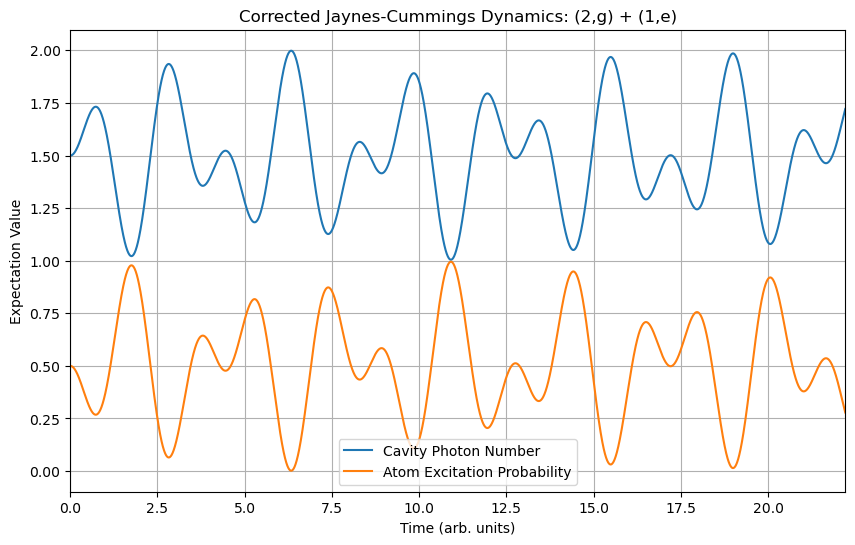

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# =============================================================================
# Define Parameters
# =============================================================================
wc = 2 * np.pi   # Cavity frequency (5 GHz)
wa = 2 * np.pi   # Atom frequency (5 GHz)
g  = 2 * np.pi   # Coupling strength (10 MHz)

g_eff = g / wc       # Dimensionless coupling strength

# =============================================================================
# Define Operators
# =============================================================================
n_cavity = 15  # Increased number of cavity Fock states

a = tensor(destroy(n_cavity), qeye(2))  
adag = a.dag()   
num_cav = adag * a  

sm = tensor(qeye(n_cavity), sigmam())  
sp = tensor(qeye(n_cavity), sigmap())  
sz = tensor(qeye(n_cavity), sigmaz())  

# =============================================================================
# Corrected Jaynes-Cummings Hamiltonian
# =============================================================================
H_theoretical = num_cav + 0.5 * sz + g_eff * (a.dag() * sm + a * sp)

# =============================================================================
# Correct Initial State: |2,g⟩ + |1,e⟩
# =============================================================================
psi1 = (1/np.sqrt(2)) * tensor(fock(n_cavity, 2), basis(2, 0))
psi2 = (1/np.sqrt(2)) * tensor(fock(n_cavity, 1), basis(2, 1))

psi0 = psi1 + psi2

# =============================================================================
# Time Evolution Setup
# =============================================================================
T_R = 2 * np.pi / (2 * g_eff * np.sqrt(2))  # Rabi period for n=2
times = np.linspace(0, 10 * T_R, 5000)  # More oscillations, but fewer steps to reduce precision errors

# Solve the time evolution
result = mesolve(H_theoretical, psi0, times, c_ops=[], e_ops=[a.dag() * a, sp * sm])

# =============================================================================
# Plot Results
# =============================================================================
n_c = result.expect[0]  # Cavity photon number expectation
n_a = result.expect[1]  # Atomic excitation probability expectation

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(result.times, n_c, label="Cavity Photon Number")
axes.plot(result.times, n_a, label="Atom Excitation Probability")
axes.grid(True)
axes.legend(loc='best')
axes.set_xlabel("Time (arb. units)")
axes.set_xlim(0, 10 * T_R)
axes.set_ylabel("Expectation Value")
axes.set_title("Corrected Jaynes-Cummings Dynamics: (2,g) + (1,e)")
plt.show()


QuTiP uses inverted atomic basis! Using |g⟩ as the projection for 'excited' state.


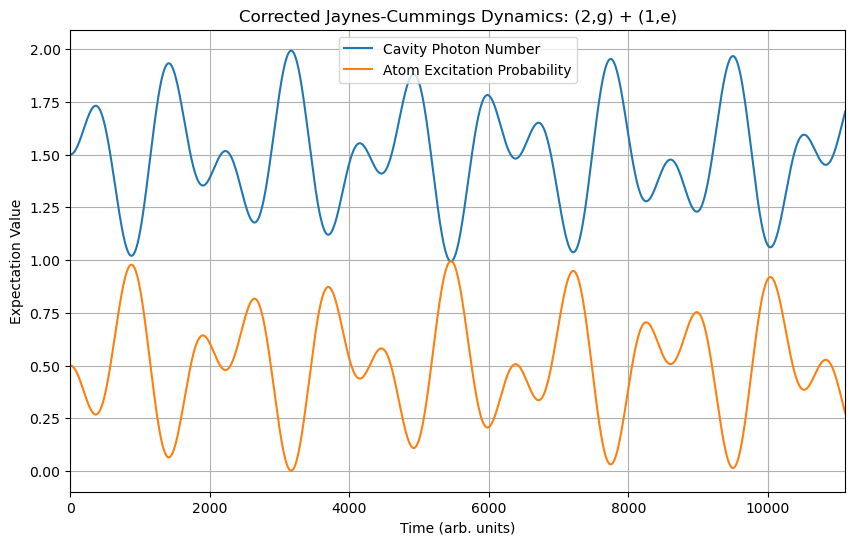

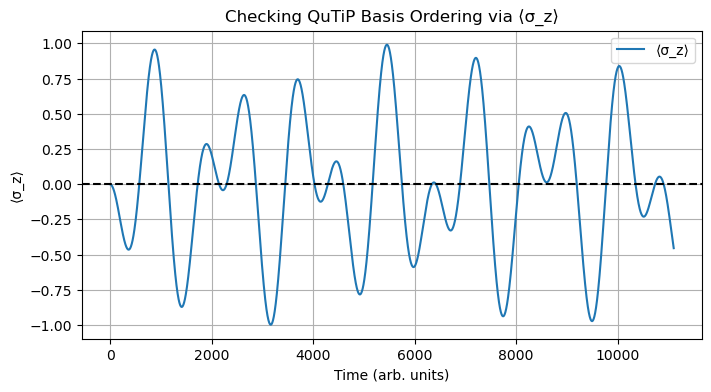

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# =============================================================================
# Define Parameters
# =============================================================================
wc = 2 * np.pi * 5e9   # Cavity frequency (5 GHz)
wa = 2 * np.pi * 5e9   # Atom frequency (5 GHz)
g  = 2 * np.pi * 1e7   # Coupling strength (10 MHz)

g_eff = g / wc       # Dimensionless coupling strength

# =============================================================================
# Define Operators
# =============================================================================
n_cavity = 15  # Increased number of cavity Fock states

a = tensor(destroy(n_cavity), qeye(2))  
adag = a.dag()   
num_cav = adag * a  

sm = tensor(qeye(n_cavity), sigmam())  
sp = tensor(qeye(n_cavity), sigmap())  
sz = tensor(qeye(n_cavity), sigmaz())  

# =============================================================================
# Corrected Jaynes-Cummings Hamiltonian
# =============================================================================
H_theoretical = num_cav + 0.5 * sz + g_eff * (a.dag() * sm + a * sp)

# =============================================================================
# Correct Initial State: |2,g⟩ + |1,e⟩
# =============================================================================
psi0 = (1/np.sqrt(2)) * (tensor(fock(n_cavity, 2), basis(2, 0)) + tensor(fock(n_cavity, 1), basis(2, 1)))

# =============================================================================
# Checking QuTiP Basis Ordering
# =============================================================================
sigma_z_atomic = sigmaz()  # Atomic-only operator
test_state = basis(2, 1)  # Expected to be |e⟩

if np.real(test_state.dag() * sigma_z_atomic * test_state) < 0:
    print("QuTiP uses inverted atomic basis! Using |g⟩ as the projection for 'excited' state.")
    excited_proj = tensor(qeye(n_cavity), basis(2, 0) * basis(2, 0).dag())  # If QuTiP flips |e⟩ and |g⟩
else:
    print("QuTiP uses standard atomic basis. Using |e⟩ as the projection.")
    excited_proj = tensor(qeye(n_cavity), basis(2, 1) * basis(2, 1).dag())  # Normal convention

# =============================================================================
# Time Evolution Setup
# =============================================================================
T_R = 2 * np.pi / (2 * g_eff * np.sqrt(2))  # Rabi period for n=2
times = np.linspace(0, 10 * T_R, 5000)  # More oscillations, but fewer steps to reduce precision errors

# Solve the time evolution
result = mesolve(H_theoretical, psi0, times, c_ops=[], e_ops=[num_cav, excited_proj, sz])

# =============================================================================
# Plot Results
# =============================================================================
n_c = result.expect[0]  # Cavity photon number expectation
n_a = result.expect[1]  # Atomic excitation probability expectation
sz_values = result.expect[2]  # Expectation value of σ_z to verify QuTiP's basis

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(result.times, n_c, label="Cavity Photon Number")
axes.plot(result.times, n_a, label="Atom Excitation Probability")
axes.grid(True)
axes.legend(loc='best')
axes.set_xlabel("Time (arb. units)")
axes.set_xlim(0, 10 * T_R)
axes.set_ylabel("Expectation Value")
axes.set_title("Corrected Jaynes-Cummings Dynamics: (2,g) + (1,e)")
plt.show()

# =============================================================================
# Verify if QuTiP Basis is Flipped
# =============================================================================
plt.figure(figsize=(8, 4))
plt.plot(result.times, sz_values, label="⟨σ_z⟩")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Time (arb. units)")
plt.ylabel("⟨σ_z⟩")
plt.title("Checking QuTiP Basis Ordering via ⟨σ_z⟩")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

# =============================================================================
# Define Experimental Parameters (in SI units)
# =============================================================================
wc = 2 * np.pi * 5e9   # cavity frequency (5 GHz)
wa = 2 * np.pi * 5e9   # atomic transition frequency (5 GHz)
g  = 2 * np.pi * 1e7   # coupling strength (10 MHz)

# =============================================================================
# Define Unitless (Dimensionless) Parameters
# =============================================================================
g_eff = g / wc       # unitless coupling
delta_eff = (wa - wc) / wc  # unitless detuning, this should be zero since wa == wc

# =============================================================================
# Set Hilbert Space Dimensions and Define Operators
# =============================================================================
n_cavity = 75  # number of cavity Fock states to include

# Define operators on the full (cavity ⊗ atom) space.
a      = tensor(destroy(n_cavity), qeye(2))   # cavity annihilation operator
adag   = a.dag()                       # cavity creation operator
num_cav = adag * a                     # cavity photon number operator

# Two-level system (atom) operators (QuTiP's basis is reversed: |0⟩ = excited, |1⟩ = ground)
sm = tensor(qeye(n_cavity), sigmam())  # atomic lowering operator
sp = tensor(qeye(n_cavity), sigmap())  # atomic raising operator
sz = tensor(qeye(n_cavity), sigmaz())  # atomic inversion

# =============================================================================
# Build the Unitary (Time-Independent) Hamiltonian
# =============================================================================
H = num_cav + 0.5 * (wa / wc) * sz + g_eff * (a * sp + adag * sm)

# =============================================================================
# Time Evolution for a Single Initial State
# =============================================================================
# The new starting state (corrected for QuTiP's inverted basis)
# QuTiP's |0> is actually the excited state, |1> is ground
psi0 = (tensor(fock(n_cavity, 2), basis(2, 0)) + tensor(fock(n_cavity, 2), basis(2, 0))).unit()

# Choose a time grid in the unitless time variable (wc*t).
t_max = 5000
n_steps = 5000
tlist = np.linspace(0, t_max, n_steps)  # Time grid

# Define the projection onto the excited state (corrected for QuTiP basis)
excited_proj = tensor(qeye(n_cavity), basis(2, 0) * basis(2, 0).dag())  # Tracks |e⟩ (QuTiP's basis(2,0))

# Solve the time-dependent Schrödinger equation (no collapse operators).
result = mesolve(H, psi0, tlist, [], [num_cav, excited_proj])

# Plot the cavity photon number and atomic excitation probability vs. time.
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label="Cavity Photon Number")
plt.plot(tlist, result.expect[1], label="Atom Excitation Probability")
plt.xlabel("Dimensionless Time (ω_c t)")
plt.ylabel("Expectation Value")
plt.title("JC Dynamics: Cavity & Atom Observables")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# Verifying the Simulation: Extracting the Rabi Frequencies
# =============================================================================
n_manifolds = np.arange(1, 11)  # simulate for n = 1,2,...,10 (total excitation numbers)
omega_exp_list = []  # will hold frequencies extracted from simulation (in units of ω_c)
omega_th_list = []   # theoretical frequencies

for n in n_manifolds:
    # Corrected initial state in QuTiP convention: |n,e> + |n-1,g>
    psi0_n = tensor(fock(n_cavity, n), basis(2, 0)) + tensor(fock(n_cavity, n-1), basis(2, 1))
    
    # Normalize the state
    psi0_n = psi0_n.unit()

    # Theoretical Rabi frequency
    Omega_theory = 2 * g_eff * np.sqrt(n)
    T_R = 2 * np.pi / Omega_theory
    omega_th_list.append(Omega_theory)
    
    # Time grid for oscillations
    t_max_n = 3 * T_R
    n_steps_n = 1000
    tlist_n = np.linspace(0, t_max_n, n_steps_n)
    
    # Solve dynamics
    result_n = mesolve(H, psi0_n, tlist_n, [], [excited_proj])
    Pe = result_n.expect[0]  # atomic excitation probability
    
    # Extract frequency from oscillations
    peaks, _ = find_peaks(Pe, height=0.5 if n < 4 else 0.5)
    
    if len(peaks) >= 2:
        T_meas = np.mean(np.diff(tlist_n[peaks]))
        Omega_meas = 2 * np.pi / T_meas
    else:
        Omega_meas = np.nan  # not enough peaks detected
    
    omega_exp_list.append(Omega_meas)

omega_exp_list = np.array(omega_exp_list)
omega_th_list = np.array(omega_th_list)

# Scatter plot comparing simulated (experimental) vs. theoretical Rabi frequencies.
plt.figure(figsize=(6, 5))
plt.scatter(n_manifolds, omega_exp_list, color='b', label="Simulated Ω")
plt.plot(n_manifolds, omega_th_list, 'r--', label="Theoretical Ω = 2 g_eff √n")
plt.xlabel("Total Excitation Number n")
plt.ylabel("Rabi Frequency (in units of ω_c)")
plt.title("Comparison of Rabi Frequencies")
plt.legend()
plt.tight_layout()
plt.show()


In [165]:
from qutip import *
import numpy as np

# Define atomic basis states in QuTiP
e_qutip = basis(2, 0)  # Expected to be |e⟩
g_qutip = basis(2, 1)  # Expected to be |g⟩

# Define sigma_z for atomic space
sigma_z_atomic = sigmaz()

# Compute expectation values
expect_e = np.real(e_qutip.dag() * sigma_z_atomic * e_qutip)
expect_g = np.real(g_qutip.dag() * sigma_z_atomic * g_qutip)

print("QuTiP Basis Definitions:")
print("e_qutip = basis(2,0):", e_qutip.full().flatten())
print("g_qutip = basis(2,1):", g_qutip.full().flatten())

print("\nEigenvalues of σ_z:")
print("⟨e|σ_z|e⟩ =", expect_e)
print("⟨g|σ_z|g⟩ =", expect_g)

# Verify tensor product structure
n_cavity = 5
psi_test = tensor(fock(n_cavity, 0), e_qutip)
expect_tensor = np.real(psi_test.dag() * tensor(qeye(n_cavity), sigma_z_atomic) * psi_test)

print("\nExpectation of σ_z in tensor space for (|0,e⟩):", expect_tensor)

QuTiP Basis Definitions:
e_qutip = basis(2,0): [1.+0.j 0.+0.j]
g_qutip = basis(2,1): [0.+0.j 1.+0.j]

Eigenvalues of σ_z:
⟨e|σ_z|e⟩ = 1.0
⟨g|σ_z|g⟩ = -1.0

Expectation of σ_z in tensor space for (|0,e⟩): 1.0


In [190]:
### TEST

In [195]:
# 3,g ; 2,e

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks

# =============================================================================
# Define Experimental Parameters (in SI units)
# =============================================================================
wc = 2 * np.pi * 5e9   # cavity frequency (5 GHz)
wa = 2 * np.pi * 5e9   # atomic transition frequency (5 GHz)
g  = 2 * np.pi * 1e7   # coupling strength (10 MHz)

# This values were defined by ChatGPT based on similarity with superconducting qubits' values.
# wc and wa are set at resonance, we might change this, but I think Florian wanted this asw.

# =============================================================================
# Define Unitless (Dimensionless) Parameters
# =============================================================================
g_eff = g / wc       # unitless coupling
delta_eff = (wa - wc) / wc  # unitless detuning, this should be zero since wa == wc, set at resonance at the beginning -^

# =============================================================================
# Set Hilbert Space Dimensions and Define Operators
# =============================================================================
n_cavity = 75  # number of cavity Fock states to include, we might increase this but it's basically the same.

# Define operators on the full (cavity ⊗ atom) space.
a      = tensor(destroy(n_cavity), qeye(2))   # cavity annihilation operator
adag   = a.dag()                       # cavity creation operator
num_cav = adag * a                     # cavity photon number operator

# Two-level system (atom) operators (QuTiP’s sigmam() and sigmap() use basis |e>,|g> with sigmaz = diag(1, -1))
sm = tensor(qeye(n_cavity), sigmam())  # atomic lowering operator
sp = tensor(qeye(n_cavity), sigmap())  # atomic raising operator
sz = tensor(qeye(n_cavity), sigmaz())  # atomic inversion

# =============================================================================
# Build the Unitary (Time-Independent) Hamiltonian
# =============================================================================
H = num_cav + 0.5 * (wa / wc) * sz + g_eff * (a * sp + adag * sm)

# =============================================================================
# Time Evolution for a Single Initial State
# =============================================================================
# The new starting state is a superposition of two states:
# psi_0 = tensor(fock(n_cavity, 1), fock(2, 1)) + tensor(fock(n_cavity, 2), fock(2, 0))
psi0 = (tensor(fock(n_cavity, 2), basis(2, 0)) + tensor(fock(n_cavity, 2), basis(2, 0))).unit()

# Choose a time grid in the unitless time variable (wc*t).
t_max = 5000
n_steps = 5000
tlist = np.linspace(0, t_max, n_steps)  # Time grid

# Define the projection onto the excited state (atom) operator:
excited_proj = tensor(qeye(n_cavity), (basis(2, 0) * basis(2, 0).dag())*1)

# Solve the time-dependent Schrödinger equation (no collapse operators).
result = mesolve(H, psi0, tlist, [], [num_cav, excited_proj])

# Plot the cavity photon number and atomic excitation probability vs. time.
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label="Cavity Photon Number")
plt.plot(tlist, result.expect[1], label="Atom Excitation Probability")
plt.xlabel("Dimensionless Time (ω_c t)")
plt.ylabel("Expectation Value")
plt.title("JC Dynamics: Cavity & Atom Observables")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# Verifying the Simulation: Extracting the Rabi Frequencies
# =============================================================================
n_manifolds = np.arange(1, 11)  # simulate for n = 1,2,...,10 (total excitation numbers)
omega_exp_list = []  # will hold frequencies extracted from simulation (in units of ω_c)
omega_th_list = []   # theoretical frequencies

for n in n_manifolds:
    # Correct initial state: |n,g> + |n-1,e>
    psi0_n = tensor(fock(n_cavity, n), basis(2, 0)) + tensor(fock(n_cavity, n-1), basis(2, 1))
    
    # Normalize the state
    psi0_n = psi0_n.unit()

    # Theoretical Rabi frequency
    Omega_theory = 2 * g_eff * np.sqrt(n)
    T_R = 2 * np.pi / Omega_theory
    omega_th_list.append(Omega_theory)
    
    # Time grid for oscillations
    t_max_n = 3 * T_R
    n_steps_n = 1000
    tlist_n = np.linspace(0, t_max_n, n_steps_n)
    
    # Solve dynamics
    result_n = mesolve(H, psi0_n, tlist_n, [], [excited_proj])
    Pe = result_n.expect[0]  # atomic excitation probability
    
    # Extract frequency from oscillations
    peaks, _ = find_peaks(Pe, height=0.5 if n < 4 else 0.5)
    
    if len(peaks) >= 2:
        T_meas = np.mean(np.diff(tlist_n[peaks]))
        Omega_meas = 2 * np.pi / T_meas
    else:
        Omega_meas = np.nan  # not enough peaks detected
    
    omega_exp_list.append(Omega_meas)

omega_exp_list = np.array(omega_exp_list)
omega_th_list = np.array(omega_th_list)

# Scatter plot comparing simulated (experimental) vs. theoretical Rabi frequencies.
plt.figure(figsize=(6, 5))
plt.scatter(n_manifolds, omega_exp_list, color='b', label="Simulated Ω")
plt.plot(n_manifolds, omega_th_list, 'r--', label="Theoretical Ω]]")
plt.xlabel("Total Excitation Number n")
plt.ylabel("Rabi Frequency (in units of ω_c)")
plt.title("Comparison of Rabi Frequencies")
plt.legend()
plt.tight_layout()
plt.show()

In [231]:
##### Time evolution comparison

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# =============================================================================
# 1) Define Experimental Parameters (in SI units)
#    We want a 10 MHz vacuum Rabi splitting, i.e. 2*g = 10 MHz => g = 5 MHz
# =============================================================================
wc = 2 * np.pi * 5e9   # cavity frequency (5 GHz)
wa = 2 * np.pi * 5e9   # atomic transition frequency (5 GHz)
g  = 2 * np.pi * 5e6   # coupling => 2*g = 10 MHz vacuum Rabi splitting

# =============================================================================
# 2) Convert to Dimensionless Parameters
#    We scale frequencies by wc, so the Hamiltonian is divided by wc.
# =============================================================================
g_eff     = g / wc             # dimensionless coupling (g / wc)
delta_eff = (wa - wc) / wc     # dimensionless detuning, zero if wa == wc

# =============================================================================
# 3) Set Hilbert-Space Dimensions and Define Operators
# =============================================================================
n_cavity = 75  # truncated Fock space for the cavity

# Define tensor-product operators for the cavity (annihilation) and two-level atom
a        = tensor(destroy(n_cavity), qeye(2)) 
adag     = a.dag()
num_cav  = adag * a

sm       = tensor(qeye(n_cavity), sigmam())  # atomic lowering
sp       = tensor(qeye(n_cavity), sigmap())  # atomic raising
sz       = tensor(qeye(n_cavity), sigmaz())  # atomic Pauli Z

# =============================================================================
# 4) Build the Jaynes–Cummings Hamiltonian in dimensionless form
#    H_dimless = a^\dagger a + 0.5*(wa/wc)*sz + g_eff*(a sp + a^\dagger sm)
# =============================================================================
H = num_cav + 0.5 * (wa / wc) * sz + g_eff * (a * sp + adag * sm)

# =============================================================================
# 5) Example of Time Evolution for a Simple Initial State
#    Let's take |2,g> + |1,e> as a test superposition (normalized).
# =============================================================================
psi0_example = (
    tensor(fock(n_cavity, 2), basis(2, 0))   # |2,g> in QuTiP's convention
    + tensor(fock(n_cavity, 2), basis(2, 0)) # |1,e>
).unit()

# For illustration, pick a time range in dimensionless units (omega_c * t)
# Enough to see multiple Rabi cycles, but not too large
t_max    = 3000
n_steps  = 2000
tlist    = np.linspace(0, t_max, n_steps)

# Projection operator onto the atomic excited state |e> = basis(2,0)
excited_proj = tensor(qeye(n_cavity), basis(2, 0) * basis(2, 0).dag())

# Solve time-dependent Schr. equation (no dissipation)
result_example = mesolve(H, psi0_example, tlist, [], [num_cav, excited_proj])

# Extract expectation values
n_cav_exp_example = result_example.expect[0]   # cavity photon number
p_e_exp_example   = result_example.expect[1]   # atomic excitation probability

# Plot the results for the example initial state
plt.figure(figsize=(8, 5))
plt.plot(tlist, n_cav_exp_example, label=r"$\langle n \rangle$ (Cavity)")
plt.plot(tlist, p_e_exp_example,   label=r"$P(e)$ (Atom)")
plt.xlabel(r"Dimensionless Time $\omega_c t$")
plt.ylabel("Expectation Value")
plt.title("Example: JC Dynamics for a Simple Superposition")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# 6) Verifying the Simulation via Standard JC Theory in the n-Excitation Manifold
# =============================================================================
# We compare the simulated evolution for the initial state:
#     |psi(0)> = |n,g> + |n-1,e>, normalized,
# with the analytic formulas (resonant JC, zero detuning):
#
#   Omega_n = 2*g_eff * sqrt(n)
#   P_e(t)   = sin^2( (Omega_n/2)* t ) = sin^2( g_eff * sqrt{n} * t )
#   <n>(t)   = n cos^2(...) + (n - 1) sin^2(...)
#
# Here n = 1..10.  The rung with total excitations "n" is precisely |n,g> + |n-1,e>.

n_manifolds = np.arange(1, 11)  # check n = 1 through 10

fig, axs = plt.subplots(2, 5, figsize=(16, 6))  # 2 rows, 5 columns
axs = axs.flatten()  # for easier indexing

for i, n in enumerate(n_manifolds):

    # (a) Build the initial state: |n,g> + |n-1,e>
    psi0_n = (
        tensor(fock(n_cavity, n),   basis(2, 0))   # |n, g>
        + tensor(fock(n_cavity, n-1), basis(2, 1)) # |n-1, e>
    ).unit()

    # (b) Rabi frequency in dimensionless units:
    Omega_n = 2.0 * g_eff * np.sqrt(n)

    # (c) A few Rabi cycles: T_n = 2π / Omega_n
    T_n     = 2.0 * np.pi / Omega_n
    t_max_n = 3.0 * T_n       # go for ~3 full oscillations
    n_steps_n = 1000
    tlist_n  = np.linspace(0, t_max_n, n_steps_n)

    # (d) Time evolve
    result_n = mesolve(H, psi0_n, tlist_n, [], [num_cav, excited_proj])
    n_cav_sim = result_n.expect[0]
    p_e_sim   = result_n.expect[1]

    # (e) Theoretical solutions
    #     P_e(t)   = sin^2(Omega_n * t/2)
    #     <n>(t)   = n cos^2(...) + (n - 1) sin^2(...)
    p_e_th   = np.sin(Omega_n * tlist_n / 2.0)**2
    n_cav_th = (n     * np.cos(Omega_n * tlist_n / 2.0)**2
                + (n-1)* np.sin(Omega_n * tlist_n / 2.0)**2)

    # (f) Plot the comparison in each subplot
    ax = axs[i]
    ax.plot(tlist_n, p_e_sim, 'b',   label="Sim P(e)")
    ax.plot(tlist_n, p_e_th,  'r--', label="Th P(e)")
    ax.set_title(f"n = {n}")
    ax.set_xlabel(r"$t\,(\omega_c t)$")
    ax.set_ylabel("P(e)")

    # Add a secondary y-axis for the photon number
    ax2 = ax.twinx()
    ax2.plot(tlist_n, n_cav_sim, 'g',  alpha=0.7, label="Sim <n>")
    ax2.plot(tlist_n, n_cav_th,  'k--',alpha=0.7, label="Th <n>")
    ax2.set_ylabel(r"$\langle n \rangle$")

    # Combine legend entries from both y-axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [1]:
##### Optimization

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.signal import find_peaks
from scipy.special import erf  # array-aware error function

##############################################################################
# Part A: The Jaynes–Cummings Setup with Driving and Rationale
##############################################################################
"""
Theory reminder for meeting and Sayak.

The standard (undriven) Jaynes–Cummings (JC) model describes the interaction between 
a two-level system (e.g., a qubit or atomic transition) and a single mode of the 
electromagnetic field (e.g., a cavity mode). Its Hamiltonian (in suitable units) is:

    H0 = ħω_c a^† a + ½ ħω_a σ_z + ħg (a σ_+ + a^† σ_-)

When the qubit and cavity are on resonance (ω_a = ω_c), one observes Rabi oscillations 
with frequencies Ω_n = 2 g √n in the n-th excitation manifold.

In many realistic scenarios, the cavity or the qubit is driven by a classical field. 
A simple way to model such a drive (assuming resonance) is to add a drive term 
proportional to (a + a^†) if driving the cavity, or (σ_+ + σ_-) if driving the qubit. 
Here we will assume a cavity drive for minimal changes:

    H_drive = Ω (a + a^†)

where Ω is the drive amplitude (with the drive frequency assumed to be at or near ω_c).
Thus the total driven JC Hamiltonian (at resonance) becomes:

    H = H0 + H_drive
      = ħω_c a^† a + ½ ħω_c σ_z + ħg (a σ_+ + a^† σ_-)
        + ħΩ (a + a^†).

In dimensionless form (dividing all frequencies by ω_c), time is scaled by 1/ω_c, and 
we can write a dimensionless drive amplitude drive_eff = Ω/ω_c.

One important task is to "tune" the driving amplitude to best match certain target 
Rabi features (e.g., verifying or shaping the system’s dynamics). If the drive is 
too weak, the system might not produce a strong enough excitation exchange; 
if it is too strong, it can induce unwanted effects or distortions.

Below, we:
  - Simulate the driven JC dynamics for different drive amplitudes,
  - Extract the “measured” Rabi frequencies from the time evolution via the peaks in 
    the atomic excitation probability,
  - Compare them to the theoretical (undriven) expression 2*g_eff*sqrt(n) for 
    certain n manifolds,
  - Compute a sum-of-squared errors (SSE) to see how close the measured frequencies 
    match that simple reference,
  - Use Bayesian Optimization to find the drive amplitude that minimizes SSE.

We set the qubit-cavity detuning to zero (perfect resonance) and only vary the drive.
As before, our "objective" is -SSE, so that maximizing -SSE is equivalent to 
minimizing SSE.
"""

# Global JC parameters (in SI units for reference)
wc_base = 2 * np.pi * 5e9   # Cavity frequency (5 GHz)
g      = 2 * np.pi * 1e7    # Coupling strength (10 MHz)

# Hilbert space dimension (number of Fock states in the cavity)
n_cavity = 75

# Define cavity and qubit operators
a    = tensor(destroy(n_cavity), qeye(2))    # Cavity annihilation
adag = a.dag()                               # Cavity creation
sm   = tensor(qeye(n_cavity), sigmam())      # Qubit lowering
sp   = tensor(qeye(n_cavity), sigmap())      # Qubit raising
sz   = tensor(qeye(n_cavity), sigmaz())      # Qubit inversion

def simulate_rabi_frequencies_with_drive(drive_amp, n_list=None):
    """
    Given a drive amplitude drive_amp (assumed resonant with wc_base),
    we build the driven JC Hamiltonian at resonance and measure Rabi frequencies 
    for manifolds in n_list. By default, we check n = 1,2,3.

    Steps:
      1. Construct H0 = (a^dagger a) + 0.5* sz + g_eff*(a σ_+ + a^dagger σ_-)
         in dimensionless units by dividing everything by wc_base.
         Then add a drive term: drive_eff*(a + a^dagger).
      2. For each n in n_list, prepare the state |n,g> + |n-1,e>, normalized.
         (Note that in QuTiP's default, |g> = basis(2,1), |e> = basis(2,0))
      3. Time evolve with QuTiP's mesolve.
      4. Identify peaks in the atomic excitation probability to measure 
         an effective Rabi frequency for each n.
      5. Compare to the simple undriven formula 2*g_eff*sqrt(n), accumulate SSE.

    Returns: SSE (sum of squared errors) for the set n_list.
    """
    if n_list is None:
        n_list = [1, 2, 3]

    # Frequencies
    wc = wc_base
    wa = wc  # On resonance => wa = wc
    g_eff = g / wc

    # Convert drive_amp (SI) to dimensionless
    drive_eff = drive_amp / wc

    # Build dimensionless Hamiltonian (time in units of 1/wc)
    # H0
    H0 = (a.dag() * a) + 0.5 * sz + g_eff * (a * sp + adag * sm)
    # Drive term
    H_drive = drive_eff * (a + adag)
    # Total Hamiltonian
    H = H0 + H_drive

    # Projector onto the excited qubit state.
    # QuTiP default => basis(2,0) is |e>.
    excited_proj = tensor(qeye(n_cavity), basis(2, 0) * basis(2, 0).dag())

    sse = 0.0  # sum of squared errors

    for n in n_list:
        if n == 0:
            # If n=0 doesn't apply
            continue
        
        # Initial state: |n,g> + |n-1,e>, normalized
        #   => g is basis(2,1), e is basis(2,0).
        psi0_n = (tensor(fock(n_cavity, n),   basis(2, 1))
                  + tensor(fock(n_cavity, n-1), basis(2, 0))).unit()

        # Theoretical Rabi frequency (undriven reference) in dimensionless units
        Omega_theory = 2.0 * g_eff * np.sqrt(n)

        # Evolve ~3 Rabi periods to capture peaks
        T_R = 2.0 * np.pi / Omega_theory
        t_max = 3.0 * T_R
        n_steps = 600
        tlist = np.linspace(0, t_max, n_steps)

        # Solve time evolution (no collapse ops => closed system)
        result_n = mesolve(H, psi0_n, tlist, c_ops=[], e_ops=[excited_proj])
        Pe = result_n.expect[0]

        # Detect peaks in the qubit excitation probability
        peaks, _ = find_peaks(Pe, height=0.4)  # threshold might need fine tuning
        if len(peaks) >= 2:
            # measure average peak-to-peak distance => T_meas
            T_meas = np.mean(np.diff(tlist[peaks]))
            Omega_meas = 2.0 * np.pi / T_meas
        else:
            Omega_meas = 0.0  # not enough peaks => big error

        # SSE contribution for manifold n
        sse += (Omega_meas - Omega_theory) ** 2

    return sse


def objective_function_drive(x):
    """
    x is array shape (1,) => x[0] = drive_amp.

    We compute SSE for the first 3 manifolds and return the NEGATIVE SSE,
    because our Bayesian Optimization code tries to maximize the objective. 
    Minimizing SSE is equivalent to maximizing (-SSE).
    """
    drive_amp = x[0]
    sse = simulate_rabi_frequencies_with_drive(drive_amp, n_list=[1, 2, 3])
    return -sse


##############################################################################
# Part B: Low-Level Bayesian Optimization 
##############################################################################
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    sqdist = np.sum((x1[:, None, :] - x2[None, :, :])**2, axis=-1)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

def posterior_predictive(X_train, Y_train, X_s,
                         length_scale=1.0, sigma_f=1.0, sigma_y=1e-8):
    X_train = np.atleast_2d(X_train)
    Y_train = np.atleast_1d(Y_train)
    X_s = np.atleast_2d(X_s)
    
    # Covariance
    K = rbf_kernel(X_train, X_train, length_scale, sigma_f)
    K_s = rbf_kernel(X_train, X_s, length_scale, sigma_f)
    K_ss = rbf_kernel(X_s, X_s, length_scale, sigma_f)
    
    # Add noise
    K += sigma_y * np.eye(len(X_train))
    
    # Inversion
    K_inv = np.linalg.inv(K)
    
    # Posterior
    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    return mu_s, cov_s

def expected_improvement(X, X_samples, Y_samples,
                         length_scale=1.0, sigma_f=1.0, sigma_y=1e-8, xi=0.01):
    mu, cov = posterior_predictive(X_samples, Y_samples, X,
                                   length_scale, sigma_f, sigma_y)
    sigma = np.sqrt(np.diag(cov))
    mu_sample_opt = np.max(Y_samples)  # best so far (we're maximizing)

    sigma = np.clip(sigma, 1e-12, None)  # avoid division by zero
    
    Z = (mu - mu_sample_opt - xi) / sigma
    pdf = np.exp(-0.5 * Z**2) / np.sqrt(2.0 * np.pi)
    cdf = 0.5 * (1.0 + erf(Z / np.sqrt(2.0)))
    
    ei = (mu - mu_sample_opt - xi) * cdf + sigma * pdf
    ei = np.maximum(ei, 0.0)
    return ei

def propose_location(X_samples, Y_samples, bounds,
                     length_scale=1.0, sigma_f=1.0, sigma_y=1e-8, xi=0.01,
                     num_points=1000):
    if len(bounds) != 1:
        raise NotImplementedError("Only 1D bounds implemented in this example.")
    
    low, high = bounds[0]
    x_grid = np.linspace(low, high, num_points).reshape(-1, 1)
    ei_vals = expected_improvement(x_grid, X_samples, Y_samples,
                                   length_scale, sigma_f, sigma_y, xi)
    idx_max = np.argmax(ei_vals)
    return x_grid[idx_max, :]

def bayesian_optimization(objective_func, bounds,
                          n_iter=10, init_points=3,
                          length_scale=1.0, sigma_f=1.0, sigma_y=1e-8, xi=0.01):
    """
    Main Bayesian Optimization loop:
      - random initial points
      - iterative propose location => evaluate objective
      - return best result

    We will track SSE = -objective, for the first 3 manifolds, so MSE = SSE/3 
    and RMSE = sqrt(MSE).
    """
    n_data_points = 3  # we measure frequencies for n=1,2,3
    best_sse_list = []
    best_mse_list = []
    best_rmse_list = []

    X_samples = []
    Y_samples = []
    np.random.seed(0)
    
    # 1) Random Initialization
    for _ in range(init_points):
        x_init = np.array([np.random.uniform(low, high) for (low, high) in bounds])
        X_samples.append(x_init)
        Y_samples.append(objective_func(x_init))
    
    X_samples = np.array(X_samples)
    Y_samples = np.array(Y_samples)
    
    # 2) Main Iterations
    for i in range(n_iter):
        x_next = propose_location(X_samples, Y_samples, bounds,
                                  length_scale, sigma_f, sigma_y, xi)
        y_next = objective_func(x_next)
        
        X_samples = np.vstack([X_samples, x_next])
        Y_samples = np.append(Y_samples, y_next)
        
        # Evaluate the best SSE so far (i.e., min SSE => max -SSE)
        best_val_so_far = np.max(Y_samples)       # best (=-SSE) so far
        best_sse_so_far = -best_val_so_far        # SSE so far
        mse_so_far = best_sse_so_far / n_data_points
        rmse_so_far = np.sqrt(mse_so_far)

        best_sse_list.append(best_sse_so_far)
        best_mse_list.append(mse_so_far)
        best_rmse_list.append(rmse_so_far)

        print(f"Iteration {i+1:02d}: x_next = {x_next}, y_next = {y_next}")

    # 3) Best solution overall
    best_idx = np.argmax(Y_samples)
    best_x = X_samples[best_idx]
    best_y = Y_samples[best_idx]
    
    print("\nBayesian Optimization finished.")
    print(f"Best drive amplitude = {best_x[0]}")
    print(f"Best objective value (-SSE) = {best_y}")

    # Plot MSE
    iteration_axis = np.arange(1, n_iter+1)
    plt.figure()
    plt.plot(iteration_axis, best_mse_list, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("MSE (SSE / 3)")
    plt.title("Bayesian Optimization: MSE vs. Iteration")
    plt.tight_layout()
    plt.show()

    # Plot RMSE
    plt.figure()
    plt.plot(iteration_axis, best_rmse_list, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("RMSE (sqrt(MSE))")
    plt.title("Bayesian Optimization: RMSE vs. Iteration")
    plt.tight_layout()
    plt.show()

    return best_x, best_y, X_samples, Y_samples, best_sse_list, best_mse_list, best_rmse_list


##############################################################################
# Part C: Comparison of Non-Driven vs. Driven+Optimized
##############################################################################
"""
We now compare:
  1) A baseline with no drive (drive_amp=0).
  2) The optimized drive amplitude found via Bayesian Optimization 
     within some chosen range, e.g. [0, 0.2].

We then compare their SSE. A lower SSE indicates better matching of 
the "observed" Rabi frequencies to the simple reference formula.
"""

if __name__ == "__main__":

    # 1) Baseline "non-driven" amplitude:
    baseline_drive = 0.0
    baseline_sse = simulate_rabi_frequencies_with_drive(baseline_drive, n_list=[1,2,3])
    print(f"[Baseline] drive_amp = {baseline_drive}, SSE = {baseline_sse}")

    # 2) Bayesian Optimization to find a better drive_amp in [0, 0.2]
    bounds = [(0.0, 0.2)]
    n_iter_bo = 50
    init_points = 5

    best_x, best_val, X_samples, Y_samples, best_sse_list, best_mse_list, best_rmse_list = bayesian_optimization(
        objective_func=objective_function_drive,
        bounds=bounds,
        n_iter=n_iter_bo,
        init_points=init_points,
        length_scale=0.02,
        sigma_f=1.0,
        sigma_y=1e-6,
        xi=0.01
    )

    # best_val is the best "negative SSE", so to get the SSE:
    best_sse = -best_val

    print("\nComparison of SSE:")
    print(f" - Baseline SSE at drive=0.0: {baseline_sse:.6f}")
    print(f" - Optimized SSE at drive={best_x[0]:.6f}: {best_sse:.6f}")

    # Simple bar chart comparison
    plt.figure()
    plt.bar(['No Drive (Ω=0)', 'Optimized Drive (Ω=%.3f)' % best_x[0]],
            [baseline_sse, best_sse])
    plt.ylabel("SSE (sum of squared errors)")
    plt.title("Comparison of Non-Driven vs. Bayesian Optimized Driving")
    plt.show()


[Baseline] drive_amp = 0.0, SSE = 0.05318324380090091


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 